# Detecció de parla falsa mitjançant Intel·ligència Artifical

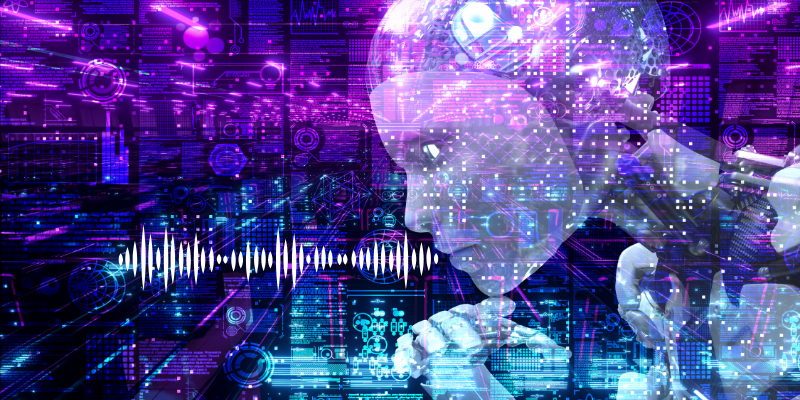

In [1]:
pip install pandas seaborn plotly descartes geopandas librosa opensmile audb pyarrow

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Map 1 library
import plotly.express as px

# Map 2 libraries
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Librosa Libraries
import librosa
import librosa.display
import IPython.display as ipd

import sklearn

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_csv = pd.read_csv("./training_set.csv")
test_csv = pd.read_csv("./test_set.csv")
full_csv = pd.read_csv("./full_habla_updated_metadata.csv")

train_csv['Realornot'].value_counts()

Realornot
1    8939
0    8865
Name: count, dtype: int64

In [4]:
train_csv['Category'].value_counts()

Category
Real           8939
StarGAN        1500
CycleGAN       1488
Diff           1488
TTS-Diff       1478
TTS-StarGAN    1478
TTS            1433
Name: count, dtype: int64

1. ANALISI ESTADÍSTIC I PREPROCESSAT DE LES DADES:

Definim el mètode data_explore() i l'utilitzem pel full_csv i per l'smile_features juntament amb el mètode describe()

In [5]:
def data_explore_n(dataframe):
    print("DATA EXPLORATION")
    print('*'*70)
    print("Shape of dataset : ",dataframe.shape)
    print('*'*70)
    print(dataframe.info())
    print('*'*70)
    print("STATISTICAL ANALYSIS OF NUMERICAL DATA")
    print('*'*70)
    print(dataframe.describe().T)
    print('*'*70)
    print("MISSING VALUES")
    print('*'*70)
    print(dataframe.isna().sum().sort_values(ascending=False))
    print('*'*70)
    print("MISSING VALUES IN %")
    print('*'*70)
    print(round(100* (dataframe.isnull().sum() / len(dataframe)).sort_values(ascending=False),2))
    print('*'*70)

In [6]:
df_smile = pd.read_csv('./smile_feature_selected.csv')
data_explore_n(df_smile)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (80816, 16)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80816 entries, 0 to 80815
Data columns (total 16 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      80816 non-null  int64  
 1   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   80816 non-null  float64
 2   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    80816 non-null  float64
 3   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1  80816 non-null  float64
 4   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  80816 non-null  float64
 5   loudness_sma3_amean                             80816 non-null  float64
 6   spectralFlux_sma3_stddevNorm                    80816 non-null  float64
 7   mf

In [7]:
df_smile.describe()

Unnamed: 0  F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
count  80816.000000                                   80816.000000   
mean   40407.500000                                     113.951954   
std    23329.714015                                     144.616993   
min        0.000000                                       0.000000   
25%    20203.750000                                      28.236189   
50%    40407.500000                                      86.174395   
75%    60611.250000                                     147.397380   
max    80815.000000                                    2087.097000   

       F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
count                                  80816.000000   
mean                                      43.353231   
std                                      114.393363   
min                                    -2448.985600   
25%                                       17.524441   
50%                                       25.106316   
75%                                       37.825207   
max                                     4659.957500   

       F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1  \
count                                    80816.000000   
mean                                        43.353231   
std                                        114.393363   
min                                      -2448.985600   
25%                                         17.524441   
50%                                         25.106316   
75%                                         37.825207   
max                                       4659.957500   

       F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  loudness_sma3_amean  \
count                                    80816.000000         80816.000000   
mean                                        47.828090             0.467605   
std                                        133.652154             0.237702   
min                                          0.000000             0.041620   
25%                                          8.628156             0.312310   
50%                                         13.888202             0.420252   
75%                                         28.633718             0.566612   
max                                       2294.165500             3.204929   

       spectralFlux_sma3_stddevNorm  mfcc1_sma3_amean  mfcc1_sma3_stddevNorm  \
count                  80816.000000      80816.000000           80816.000000   
mean                       1.446313         18.377609               0.905121   
std                        0.355365          4.111353               0.287027   
min                        0.694461         -1.798633              -5.672723   
25%                        1.185881         15.637055               0.740178   
50%                        1.411638         18.347288               0.859837   
75%                        1.659912         21.035505               1.016663   
max                        4.222191         36.090004              38.977646   

       mfcc2_sma3_amean  mfcc2_sma3_stddevNorm  mfcc3_sma3_amean  \
count      80816.000000           80816.000000      80816.000000   
mean           9.697731               4.774925         12.513296   
std            4.886923             790.898840          4.549507   
min          -10.598875           -7098.178700         -9.022558   
25%            6.677935               0.821544          9.707822   
50%           10.086592               1.168653         12.790827   
75%           13.208384               1.845684         15.659869   
max           26.485899          219881.690000         28.030746   

       mfcc3_sma3_stddevNorm  jitterLocal_sma3nz_amean  \
count           80816.000000              80816.000000   
mean                1.519714                  0.020971   
std                74.041794                  0.007419   
min             -5294.333500                  0.006094   
25%                 0.807601             

In [8]:
full_csv.describe()

File_ID  File_Source_ID  File_Target_ID  Source_Utterance  \
count  22816.000000    53000.000000    58000.000000      5.300000e+04   
mean    5318.306013     5627.025472     4978.257431      1.053960e+09   
std     2931.884349     2992.791019     2809.097043      6.262829e+08   
min      295.000000      295.000000      295.000000      6.927600e+04   
25%     2484.000000     3034.000000     2484.000000      5.018486e+08   
50%     5223.000000     5223.000000     4310.000000      1.044592e+09   
75%     8421.000000     8784.000000     7508.000000      1.584616e+09   
max     9799.000000     9799.000000     9799.000000      2.147315e+09   

       Target_Utterance     Utterance      Variant         Times      UniqueID  
count      5.300000e+04  2.281600e+04  2500.000000  80816.000000  80816.000000  
mean       1.340034e+08  1.071037e+09     0.594800    135.546699  40408.500000  
std        3.645009e+08  6.208544e+08     0.615438    194.773204  23329.714015  
min        0.000000e+00  6.927600e+04     0.000000      1.000000      1.000000  
25%        1.630400e+04  5.353323e+08     0.000000     41.000000  20204.750000  
50%        1.401600e+05  1.065023e+09     1.000000     51.000000  40408.500000  
75%        9.944568e+07  1.611582e+09     1.000000     96.000000  60612.250000  
max        2.147315e+09  2.147315e+09     2.000000    772.000000  80816.000000

In [9]:
def data_explore(dataframe):
    print("DATA EXPLORATION")
    print('*'*70)
    print("Shape of dataset : ",dataframe.shape)
    print('*'*70)
    print(dataframe.info())
    print('*'*70)
    print("STATISTICAL ANALYSIS OF NUMERICAL DATA")
    print('*'*70)
    print(dataframe.describe().T)
    print('*'*70)
    print("STATISTICAL ANALYSIS OF CATEGORICAL DATA")
    print('*'*70)
    print(dataframe.describe(exclude = ['float', 'int64']).T)
    print('*'*70)
    print("MISSING VALUES")
    print('*'*70)
    print(dataframe.isna().sum().sort_values(ascending=False))
    print('*'*70)
    print("MISSING VALUES IN %")
    print('*'*70)
    print(round(100* (dataframe.isnull().sum() / len(dataframe)).sort_values(ascending=False),2))
    print('*'*70)

data_explore(full_csv)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (80816, 25)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80816 entries, 0 to 80815
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Filename          80816 non-null  object 
 1   F_path            80816 non-null  object 
 2   F1                80816 non-null  object 
 3   F2                80816 non-null  object 
 4   F3                80816 non-null  object 
 5   F4                75816 non-null  object 
 6   ID                22816 non-null  object 
 7   File_ID           22816 non-null  float64
 8   Source_ID         53000 non-null  object 
 9   File_Source_ID    53000 non-null  float64
 10  Target_ID         58000 non-null  object 
 11  File_Target_ID    58000 non-null  float64
 12  Source_Sex        53000 non-null  obj

Visualitzem les distribucions de les variables numèriques de l'smile i del full (Utilitzem IQR per poder veure també les distribucions sense outliers)

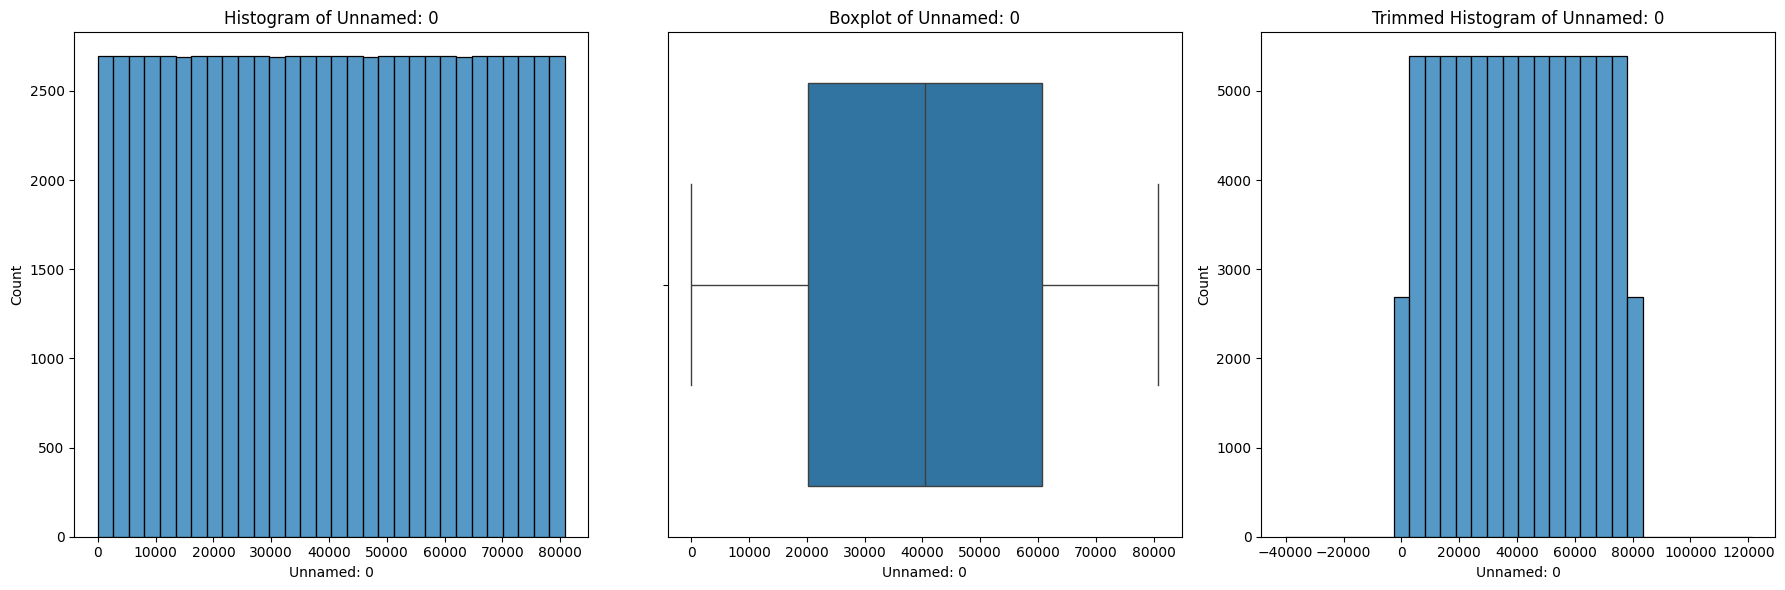

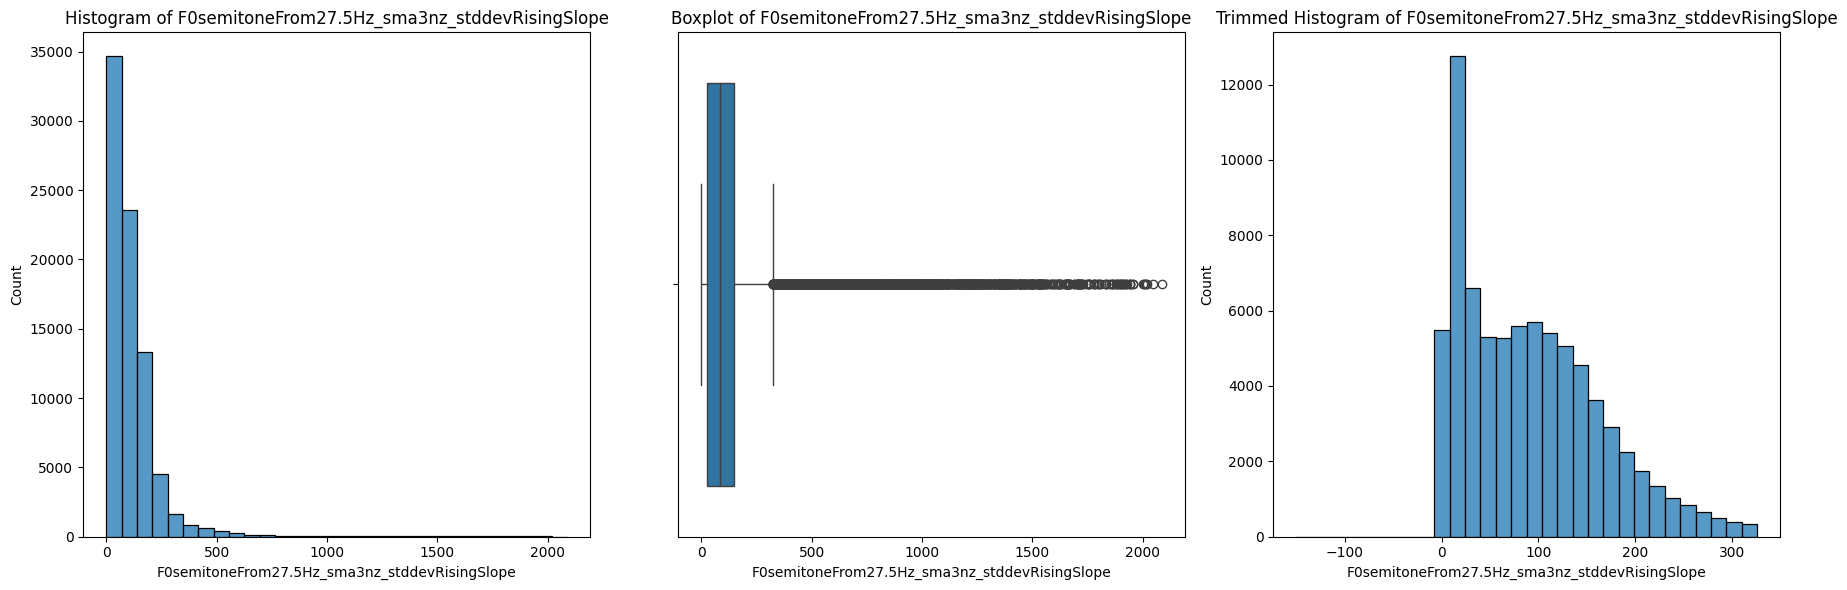

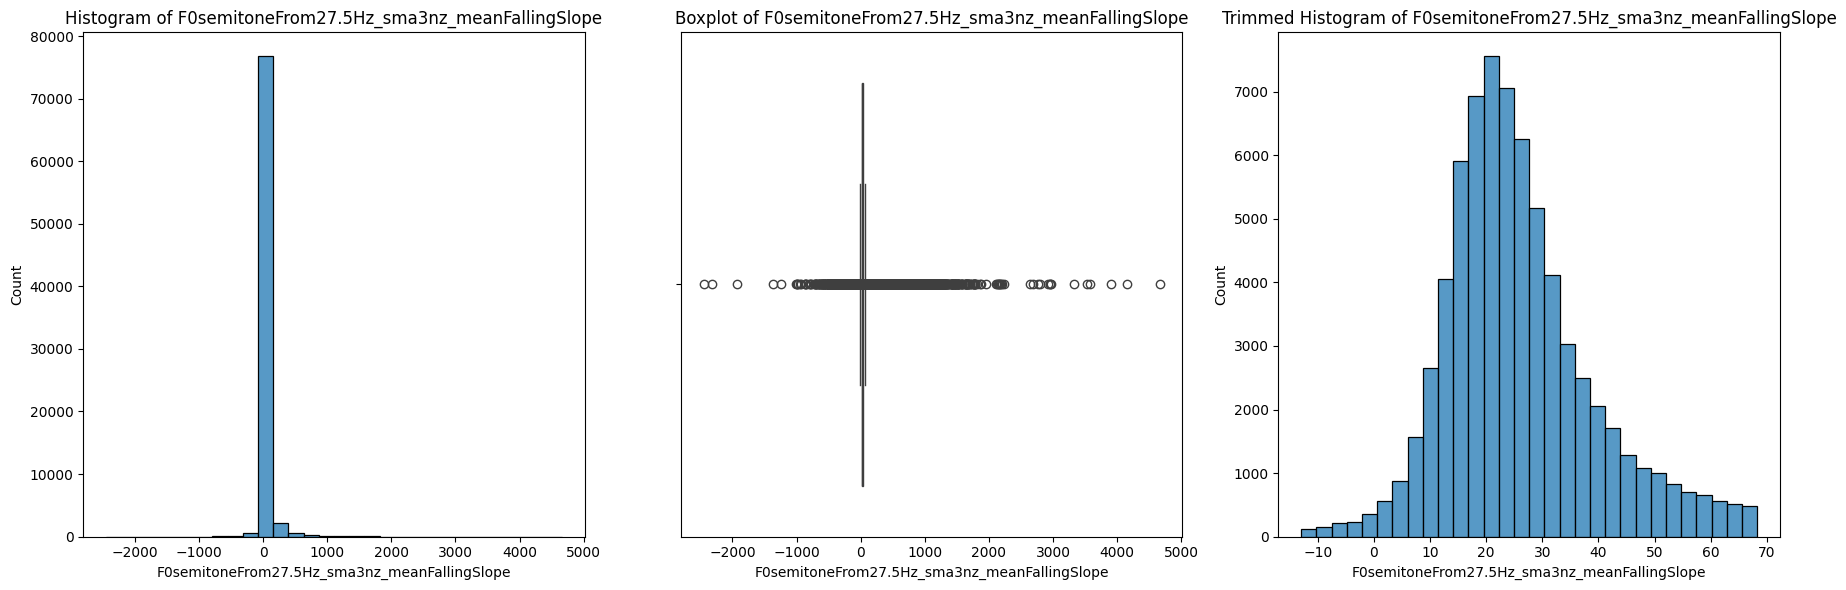

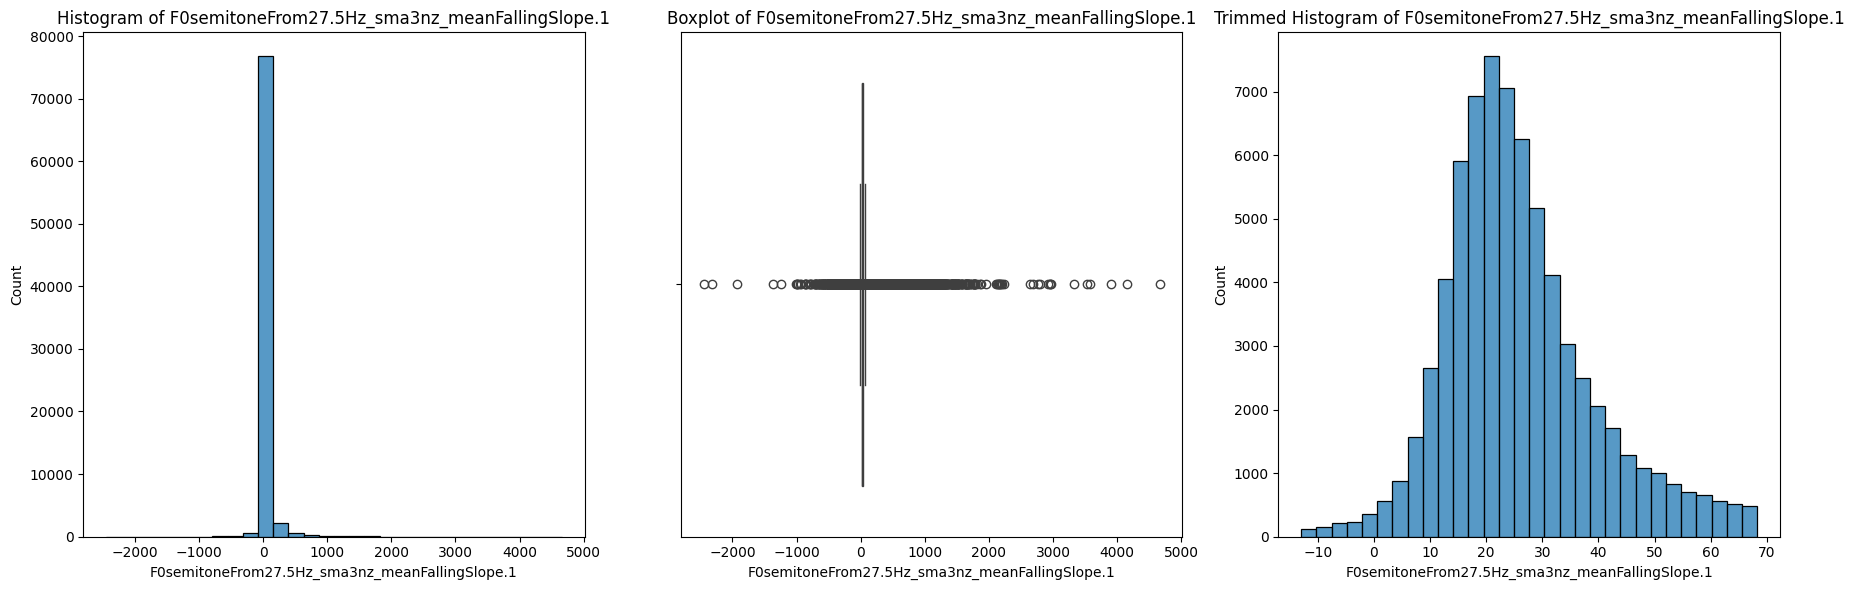

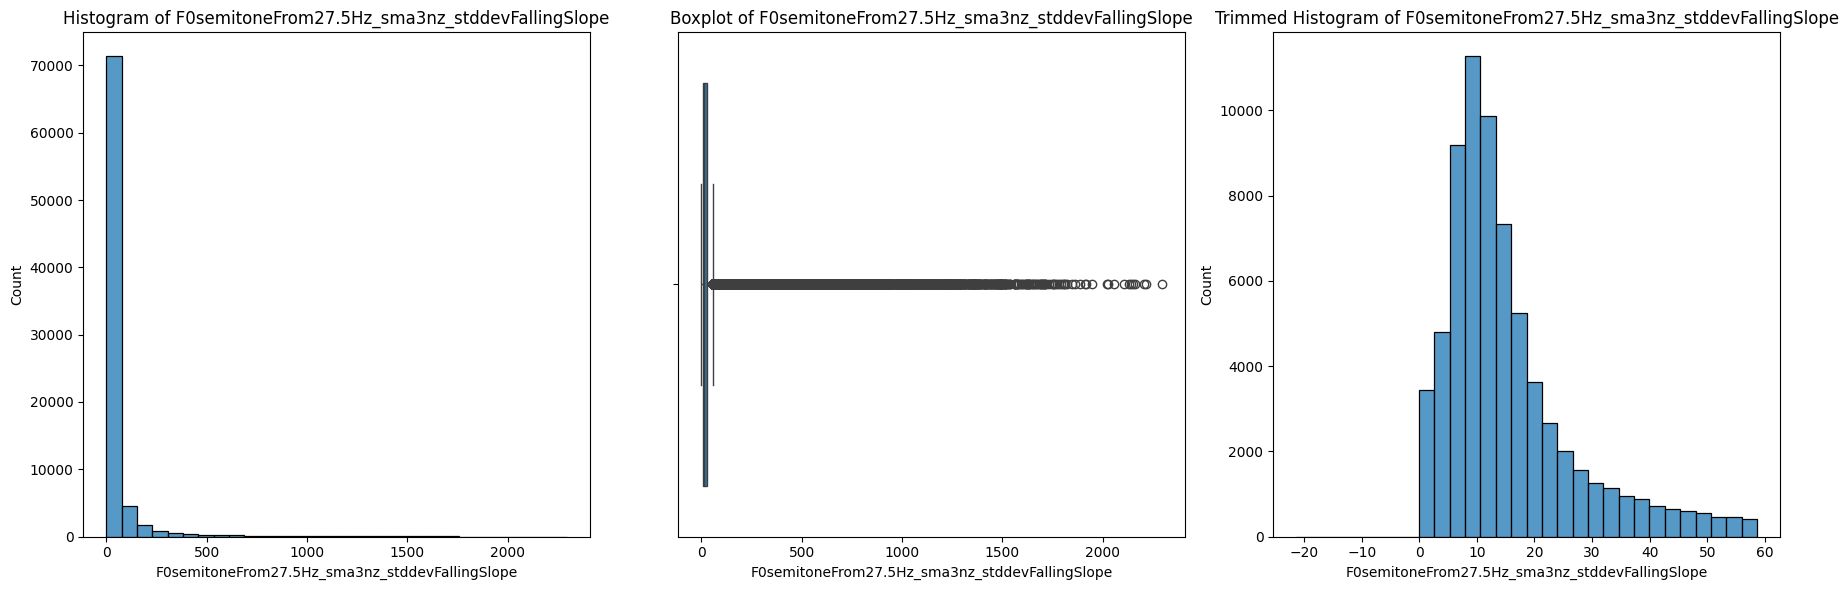

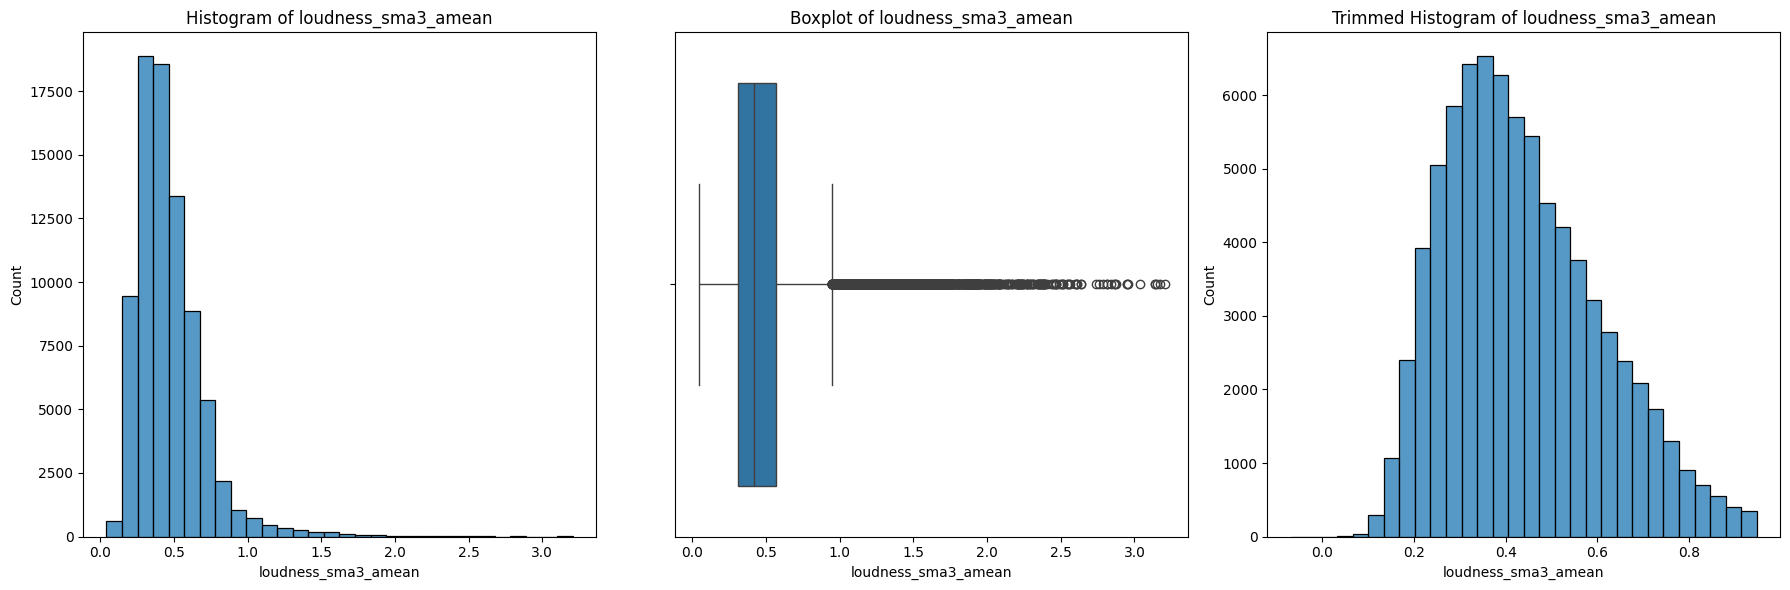

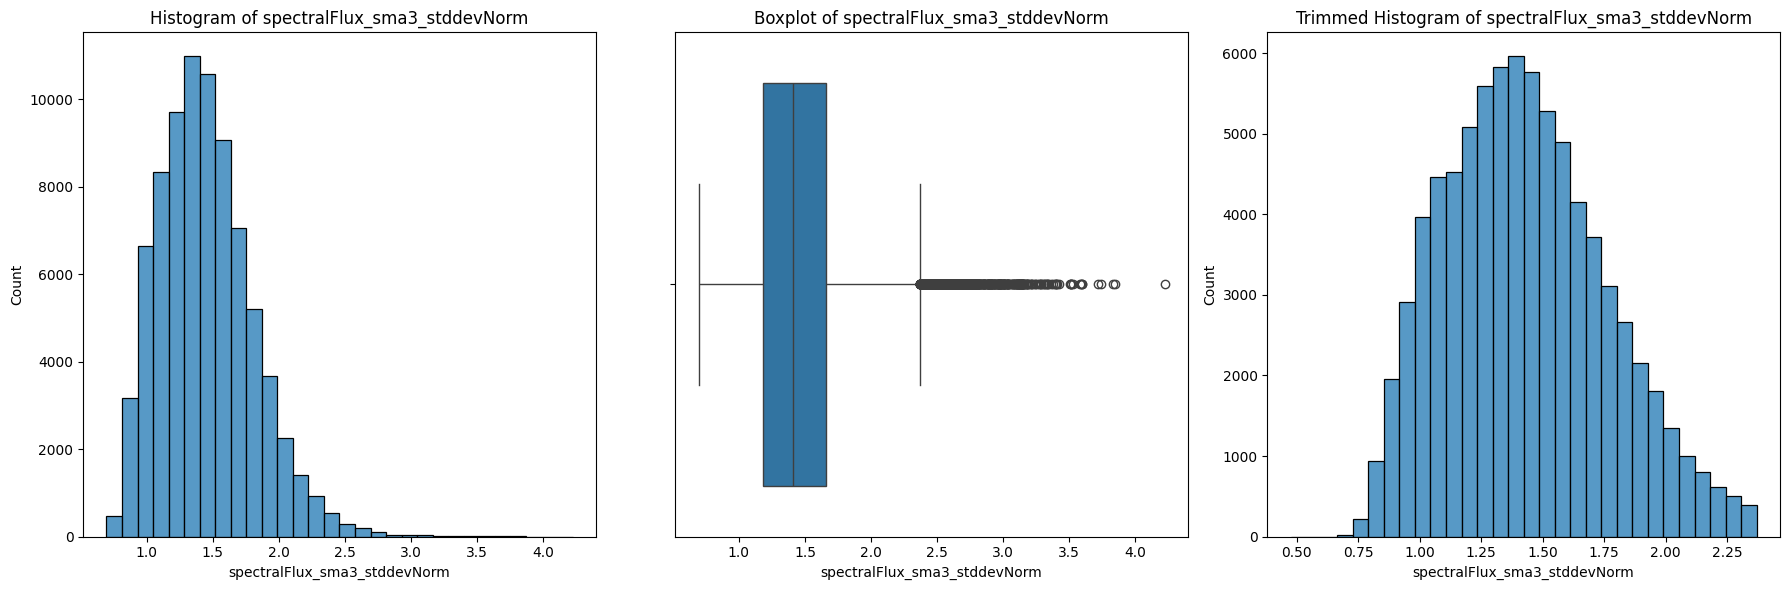

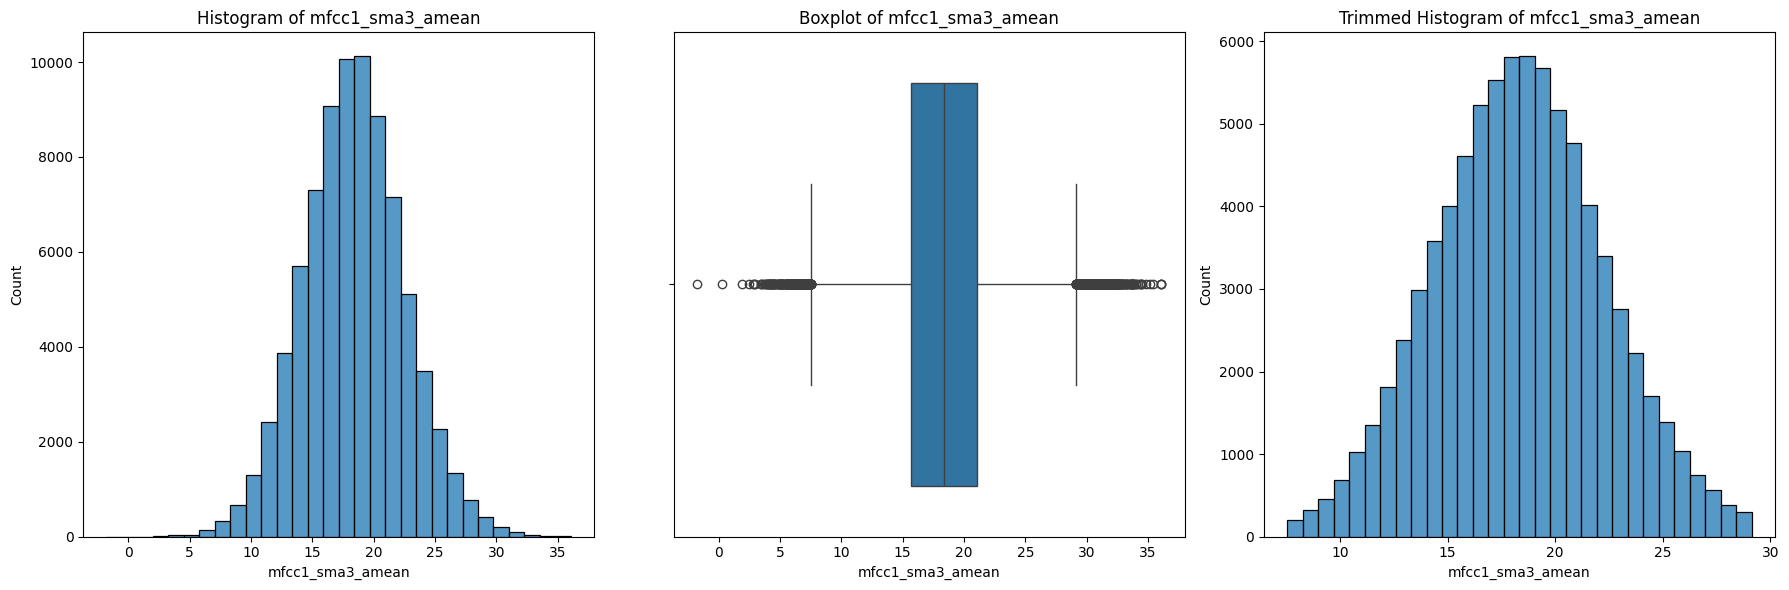

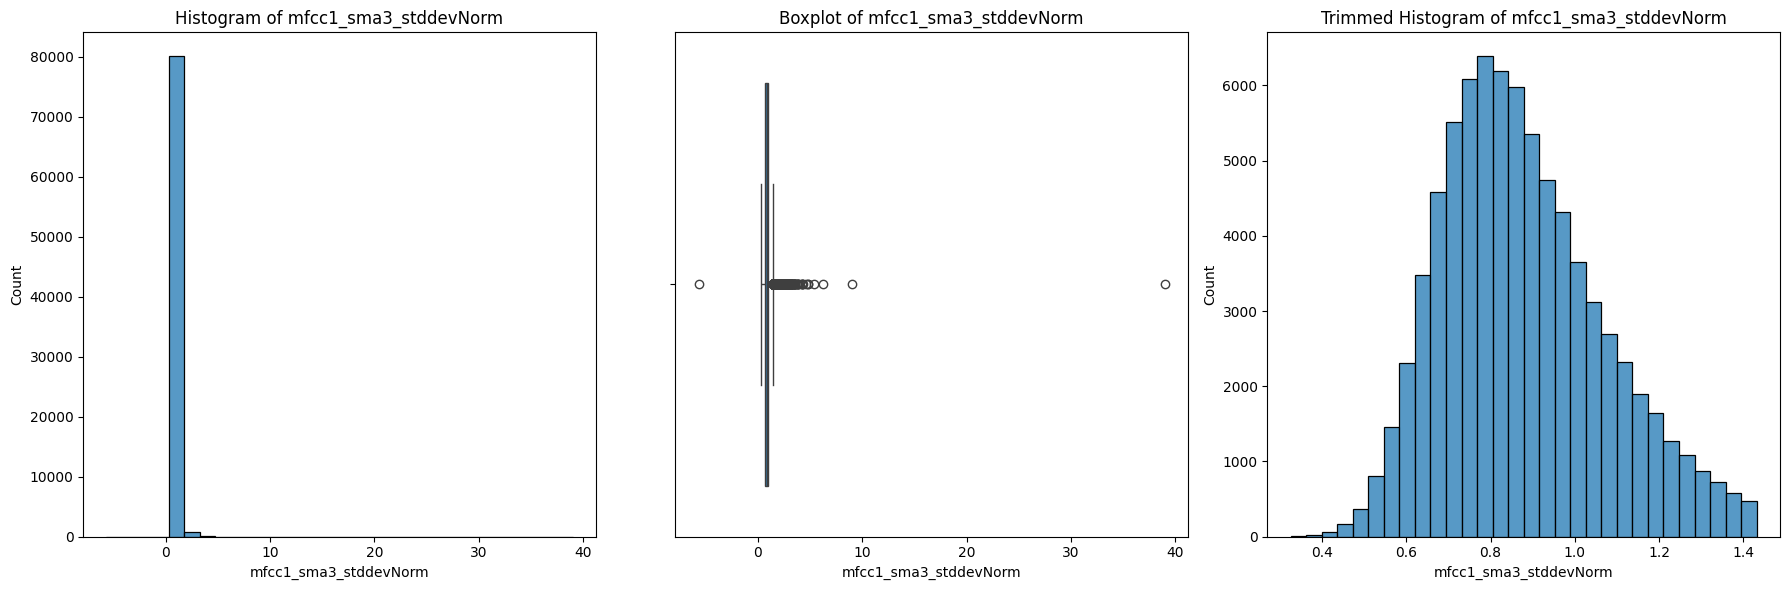

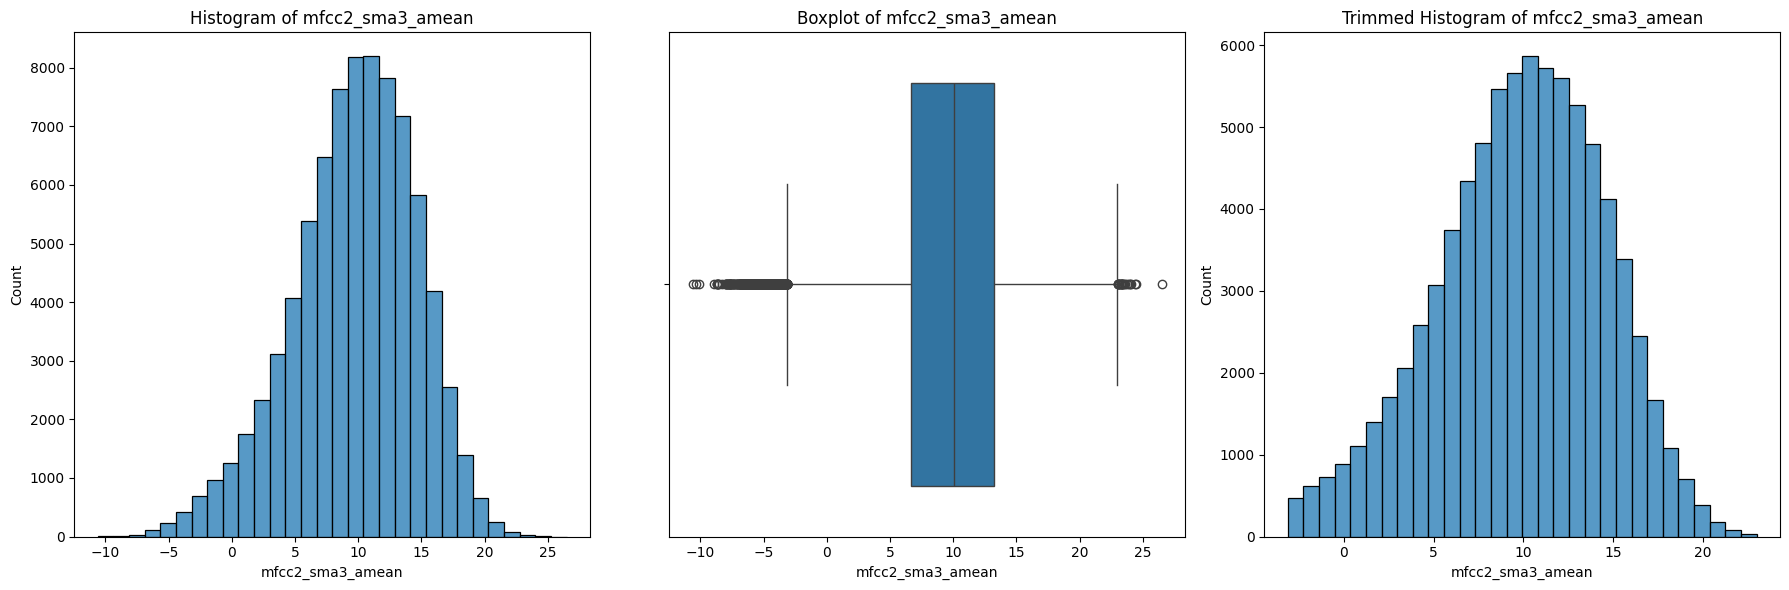

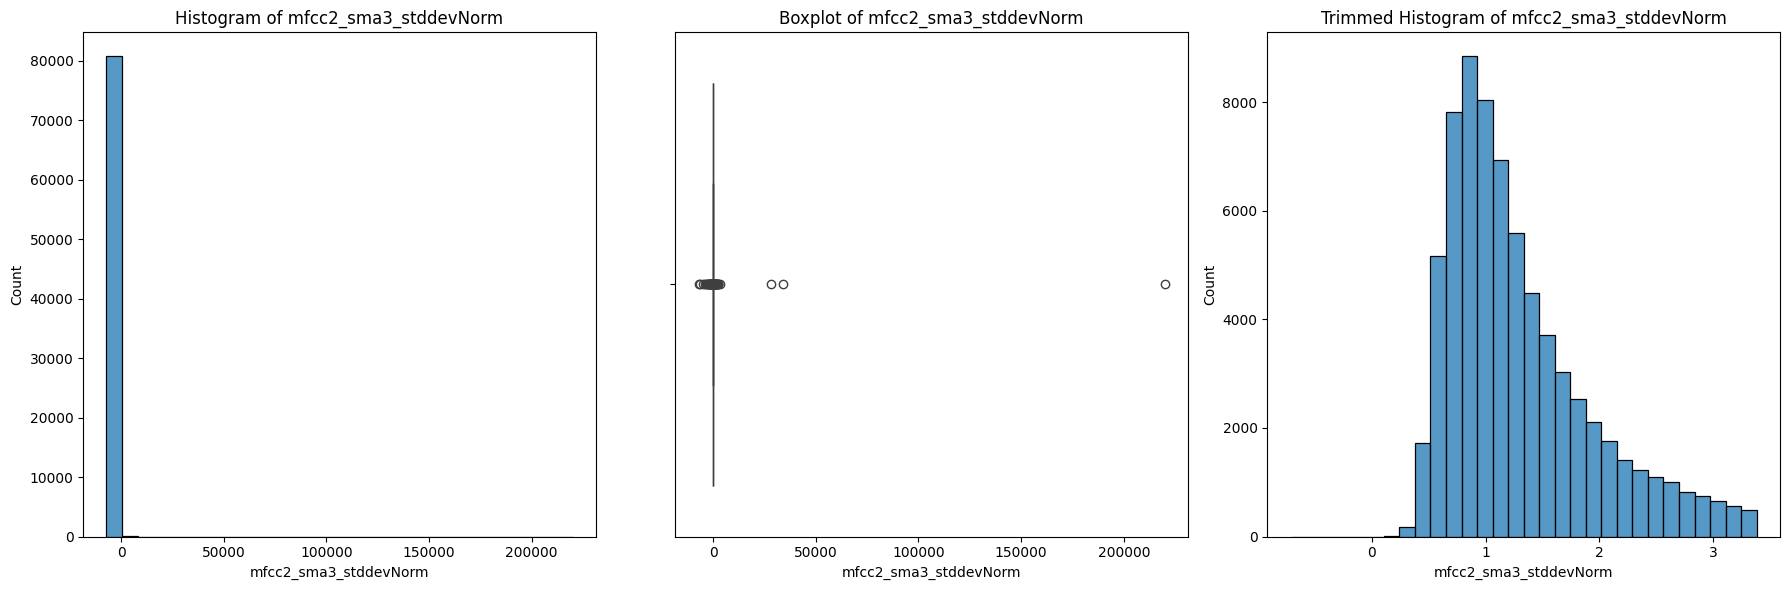

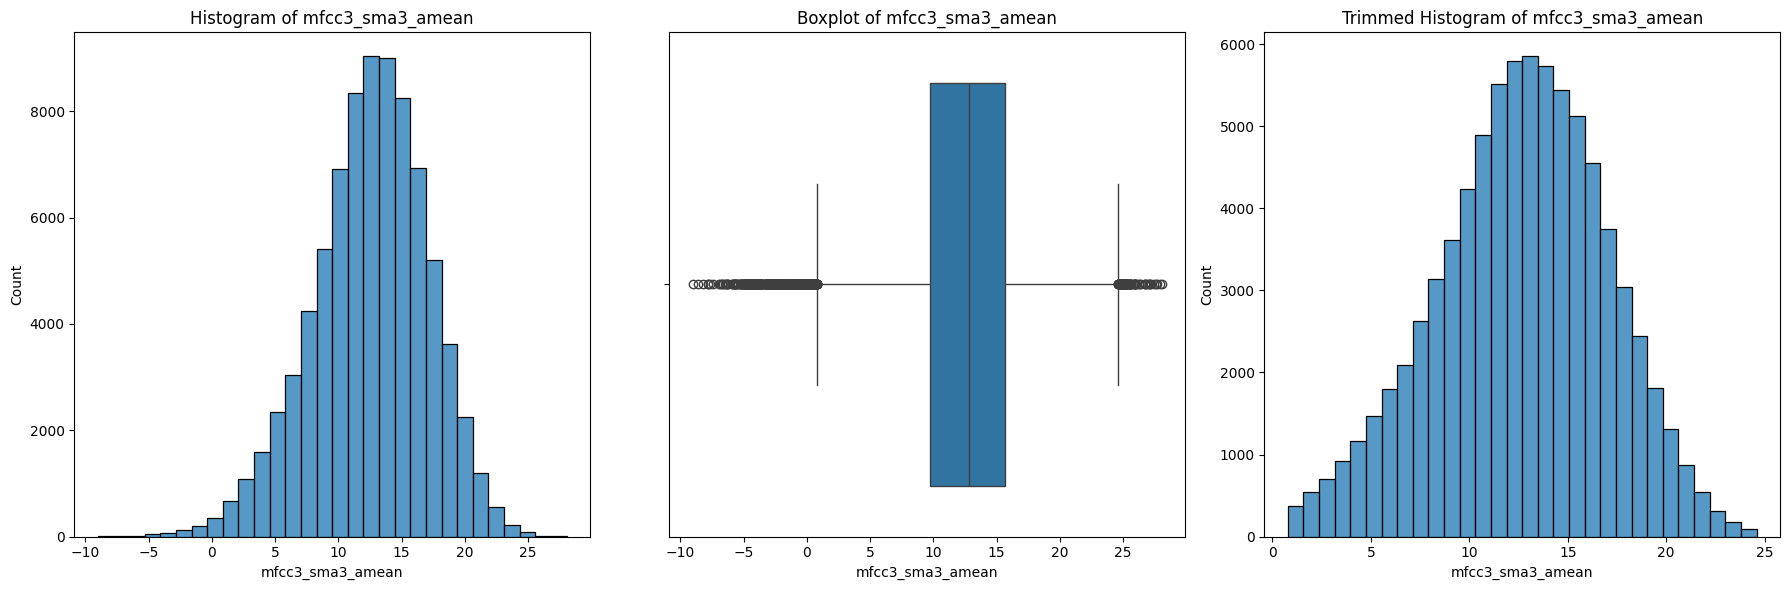

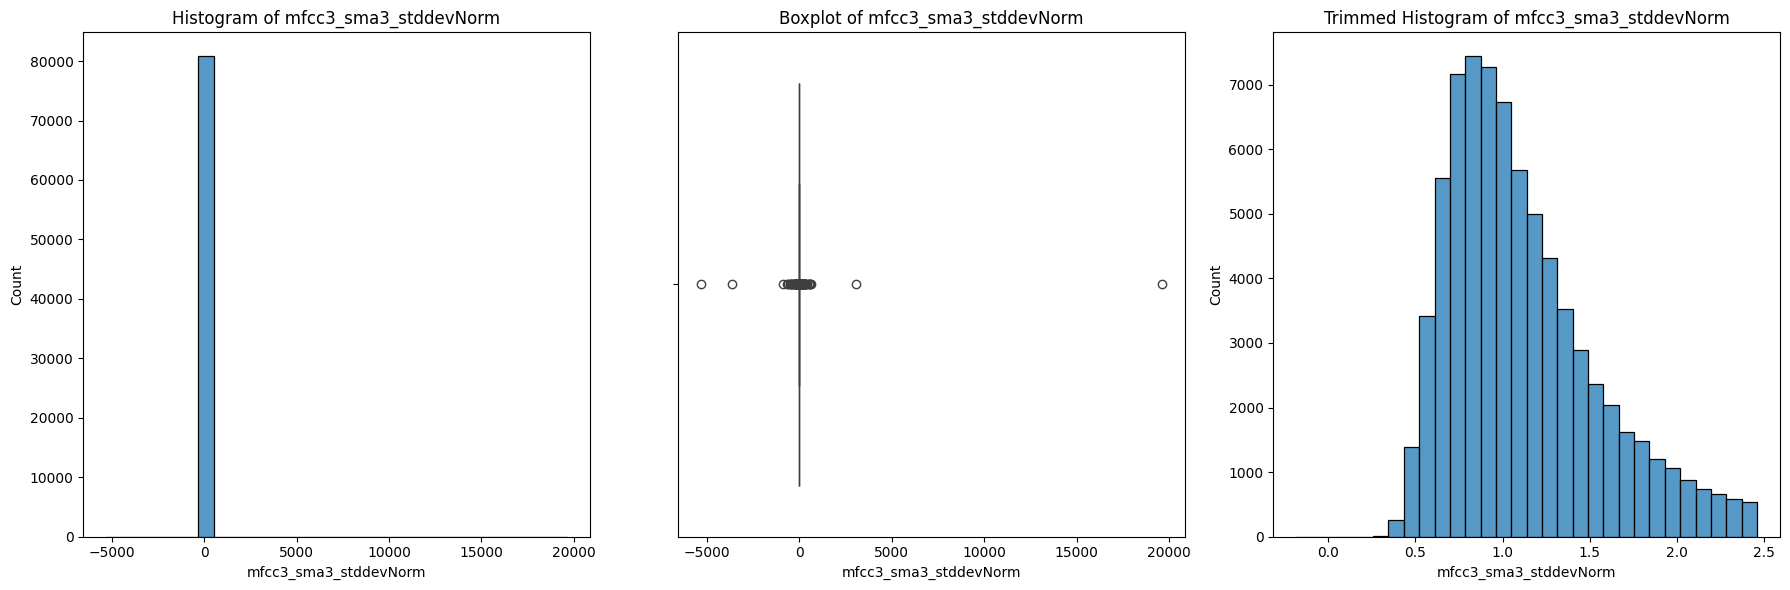

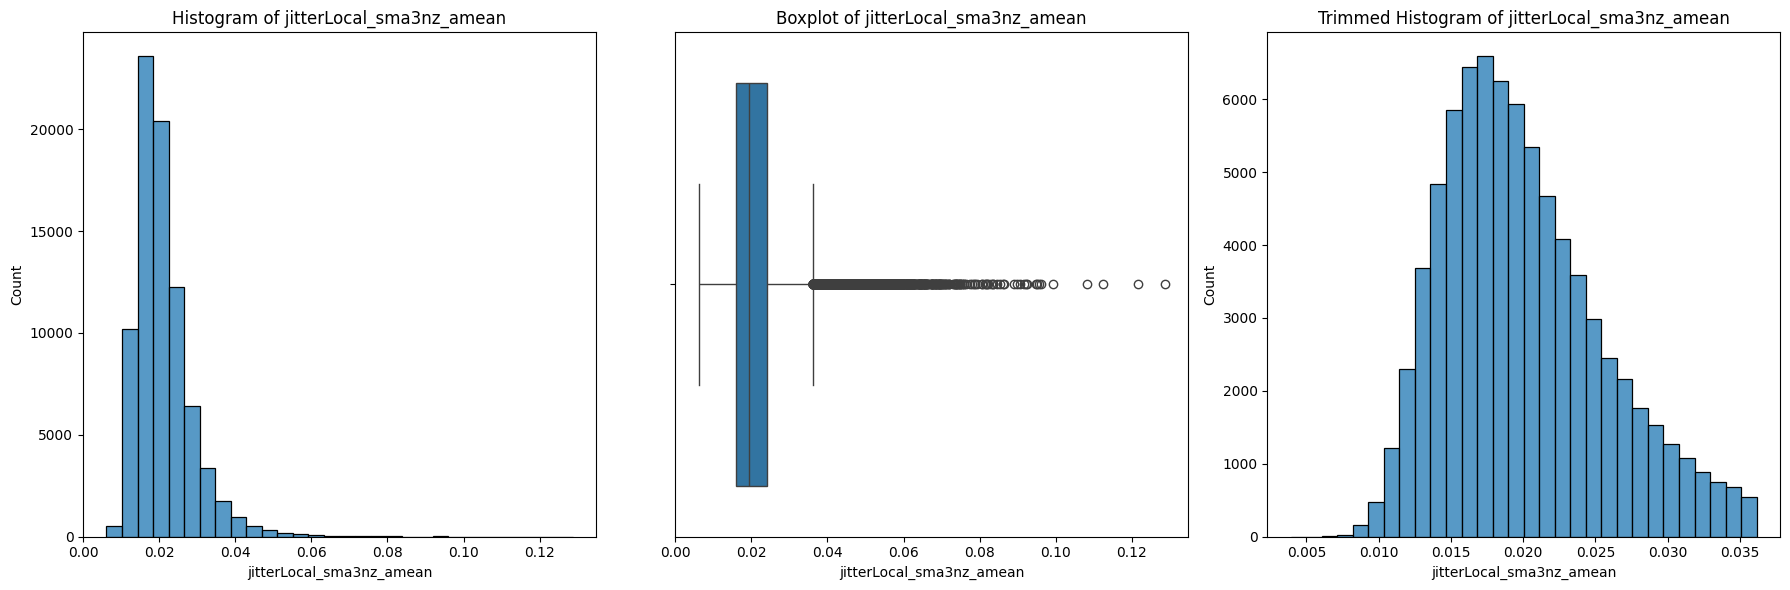

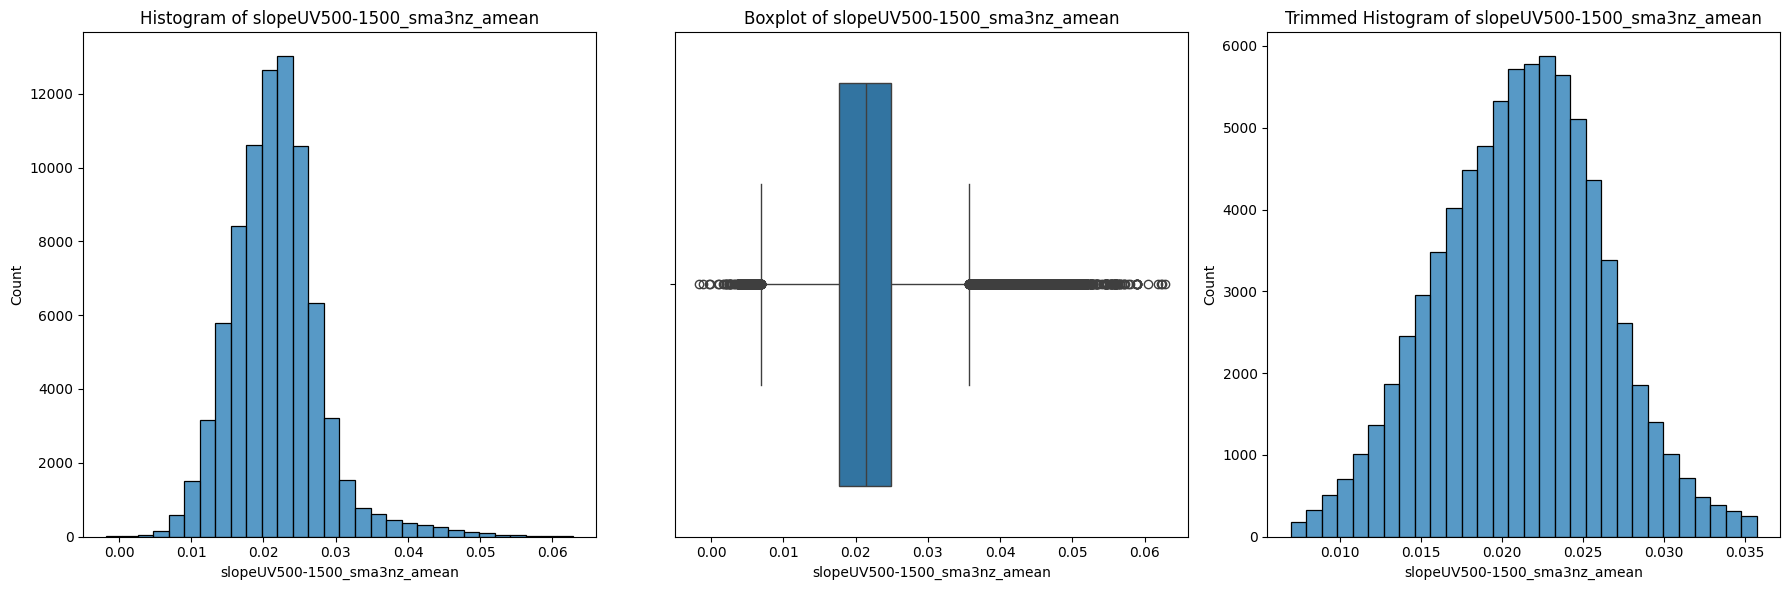

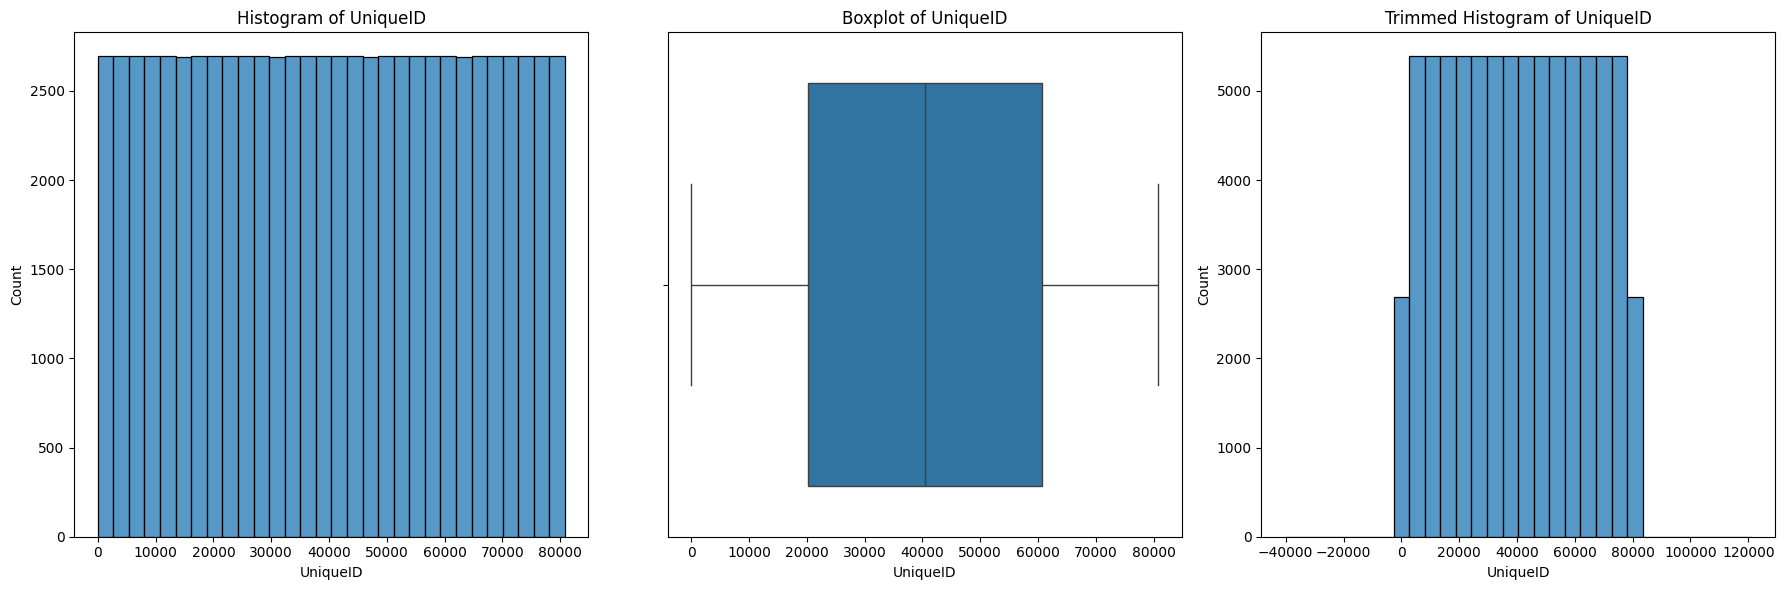

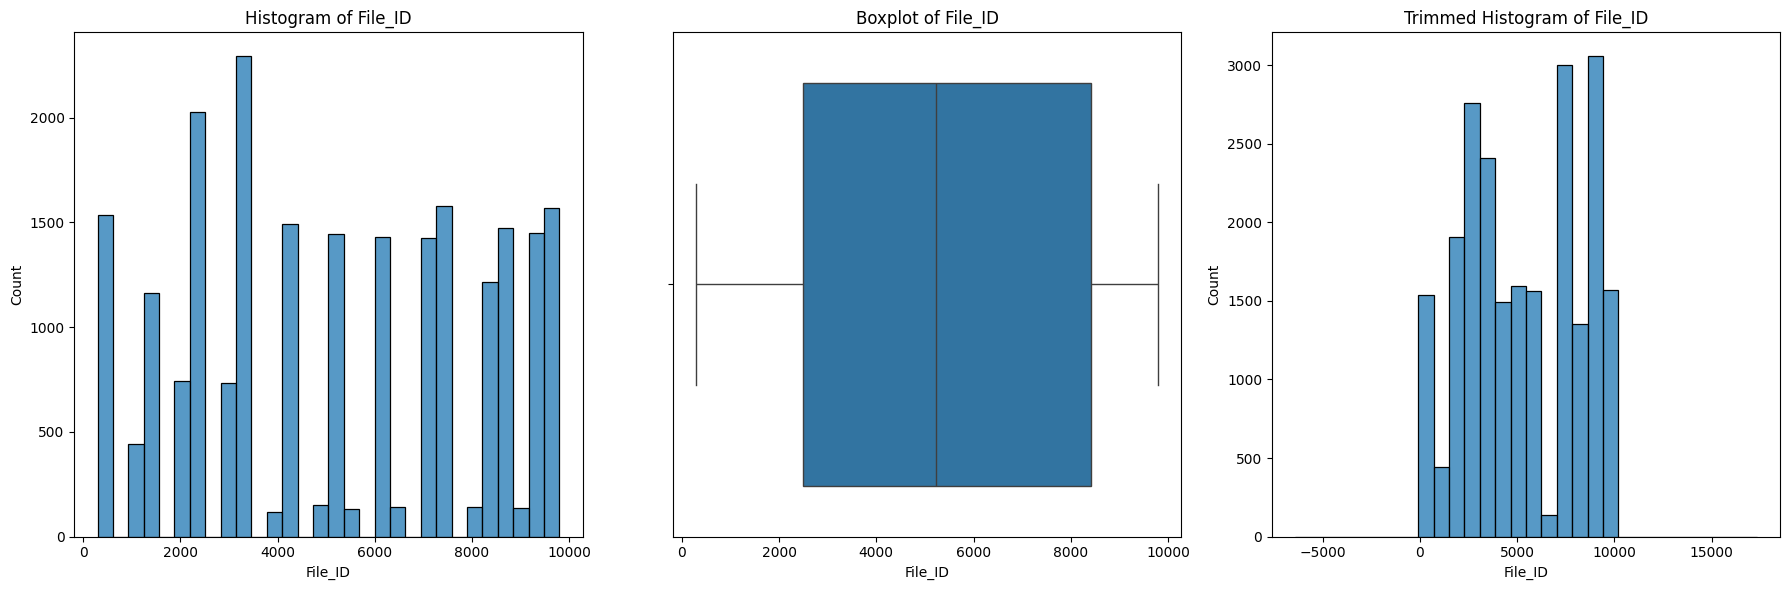

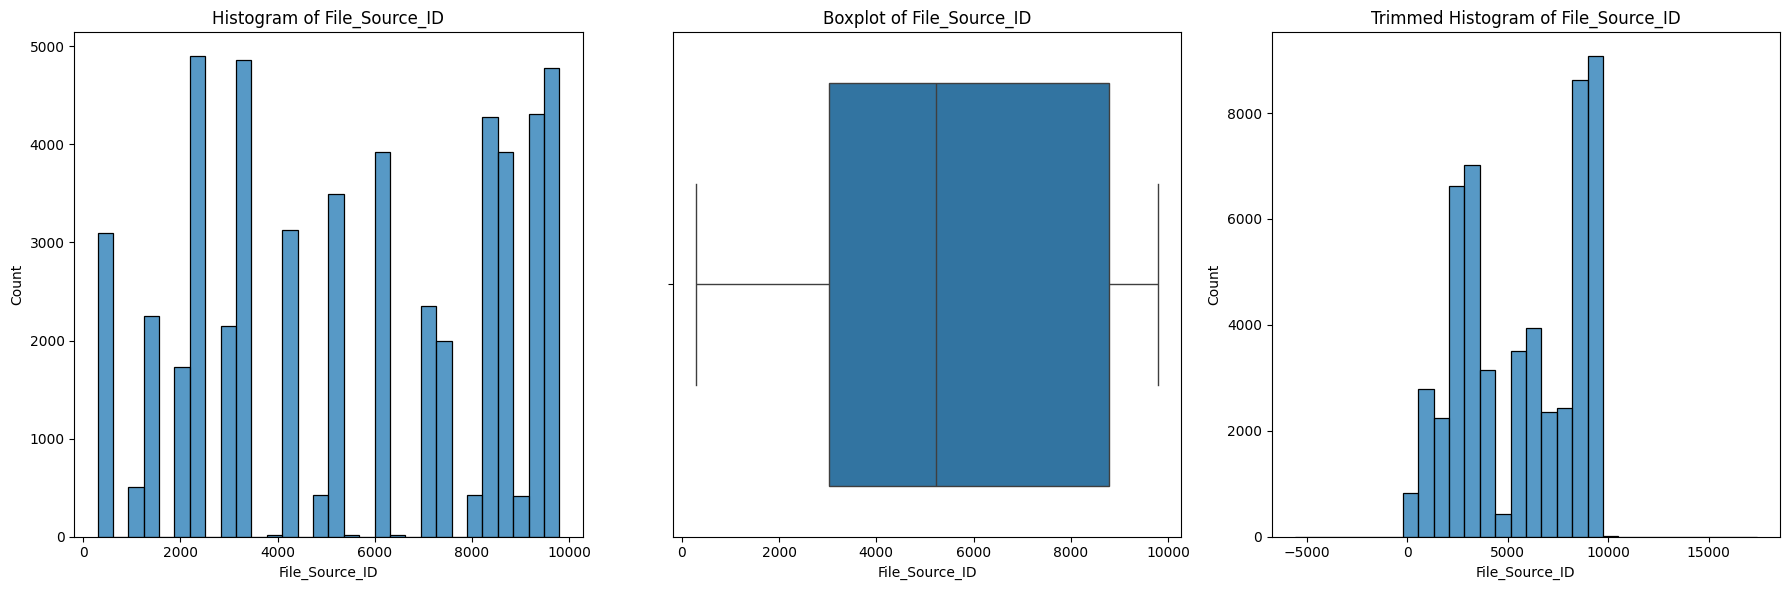

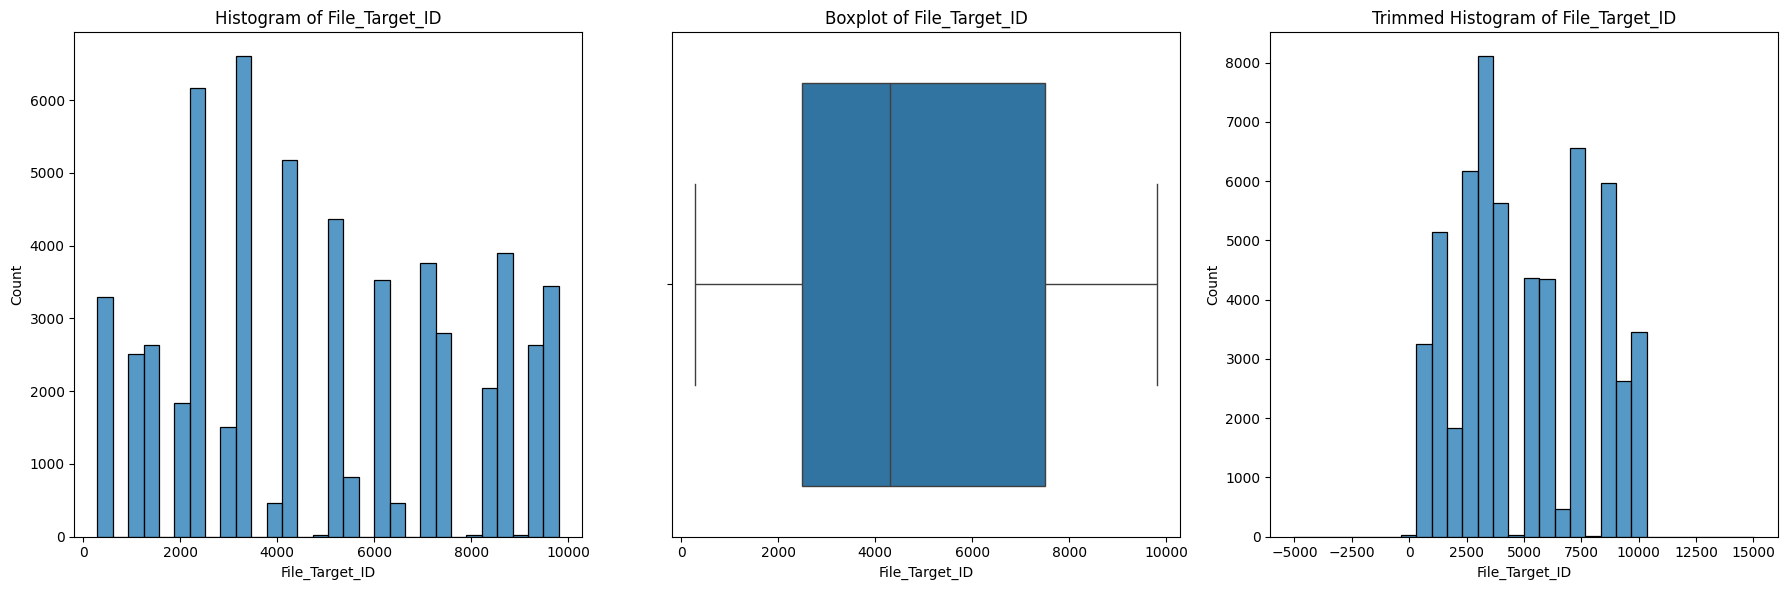

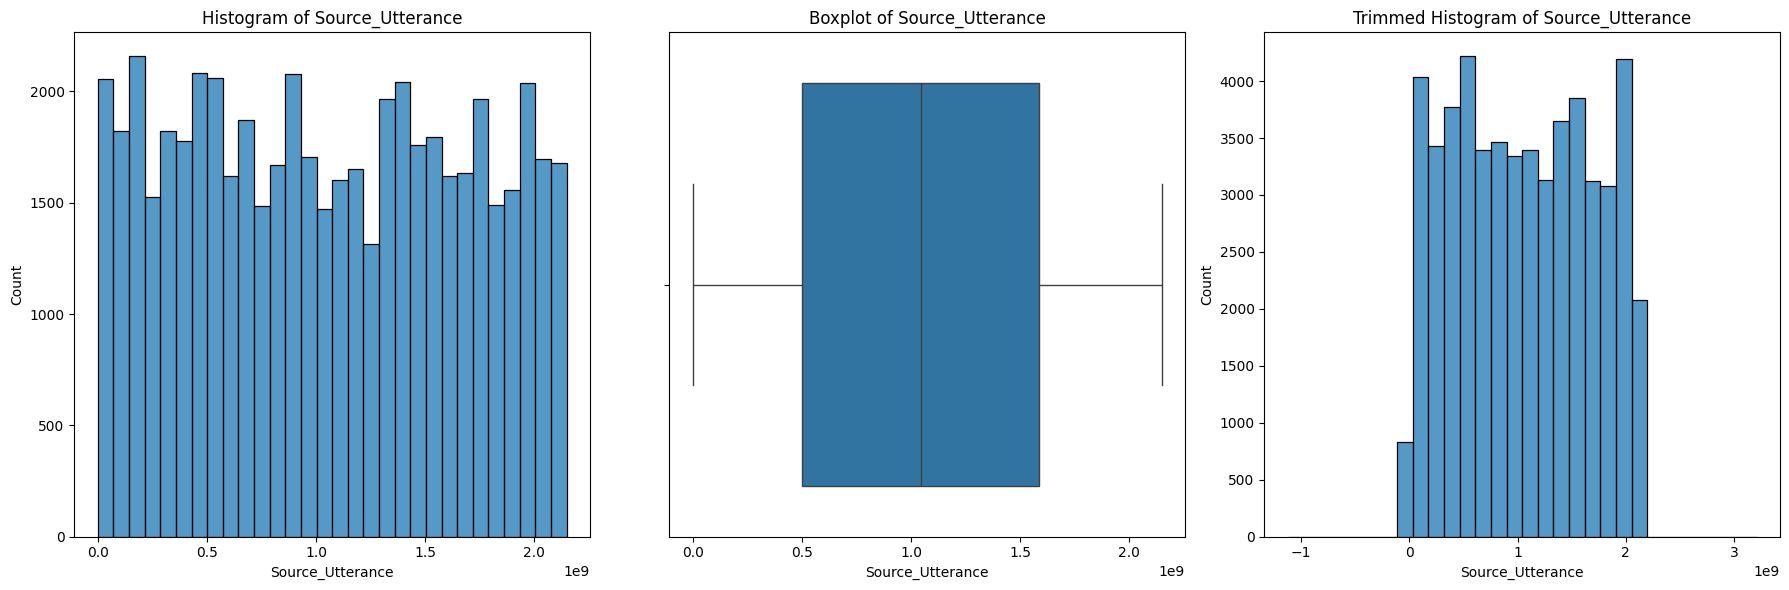

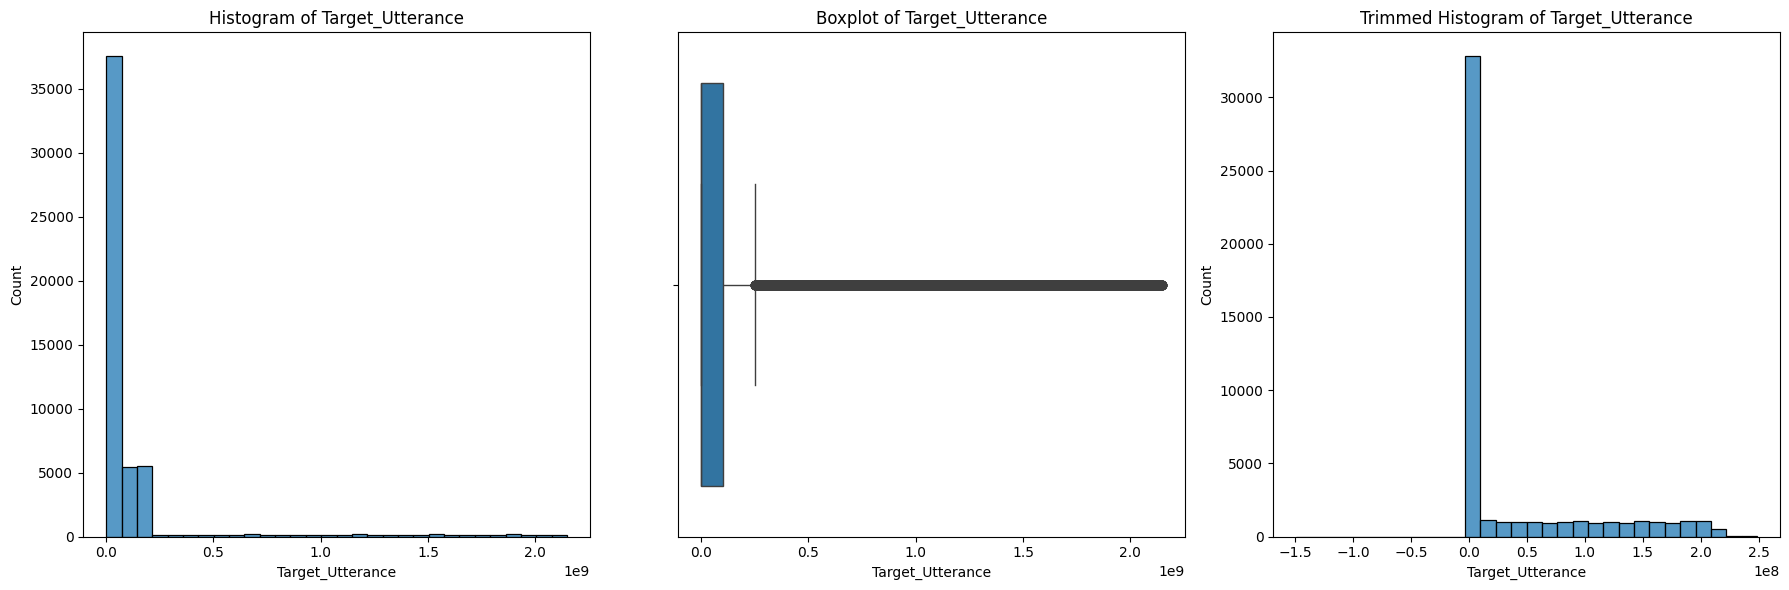

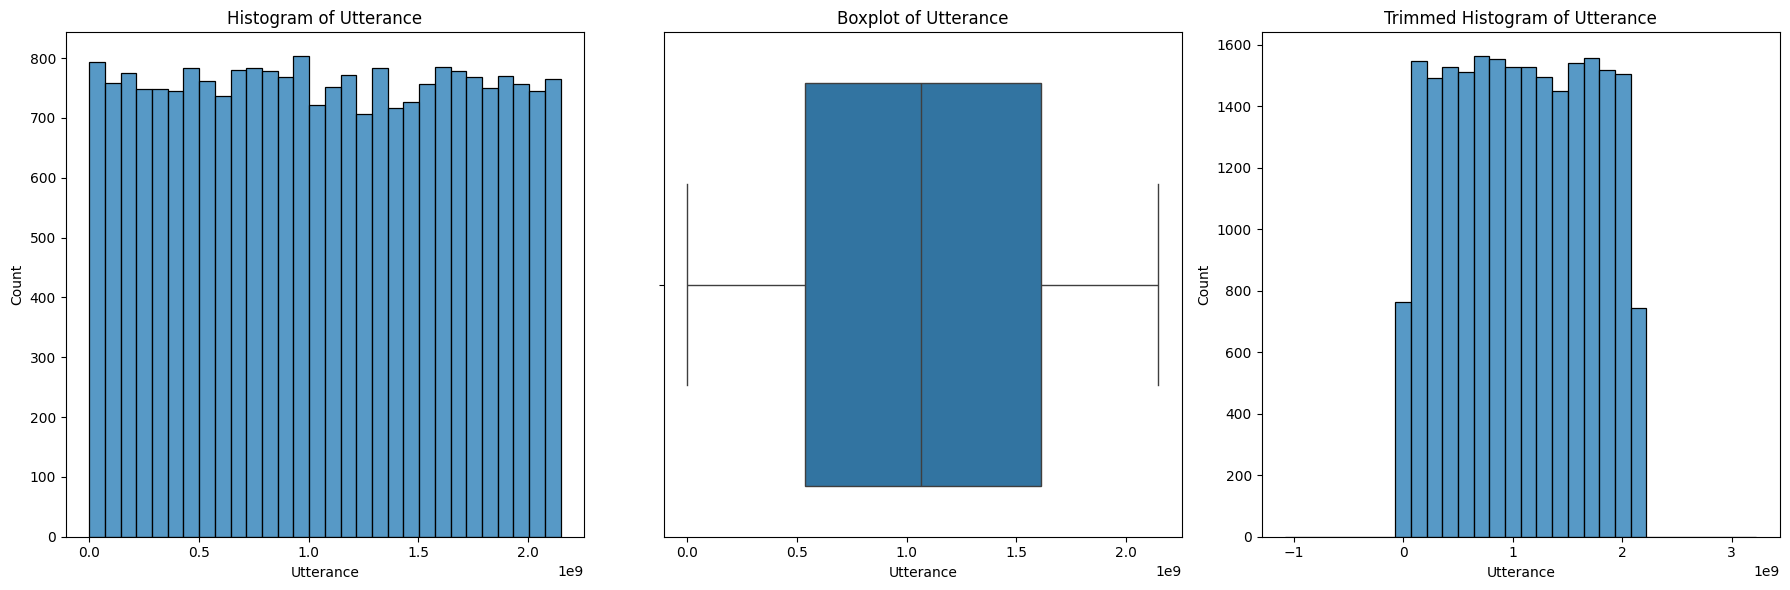

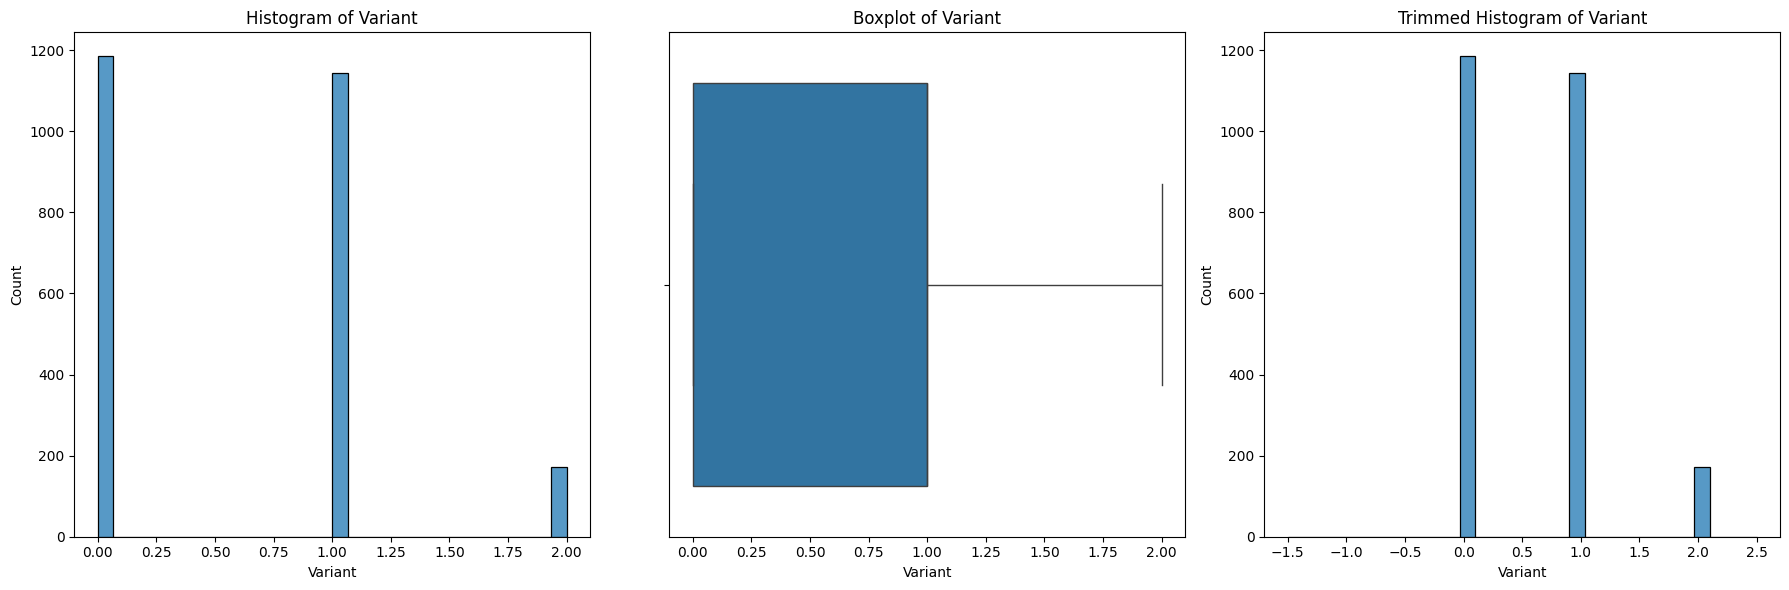

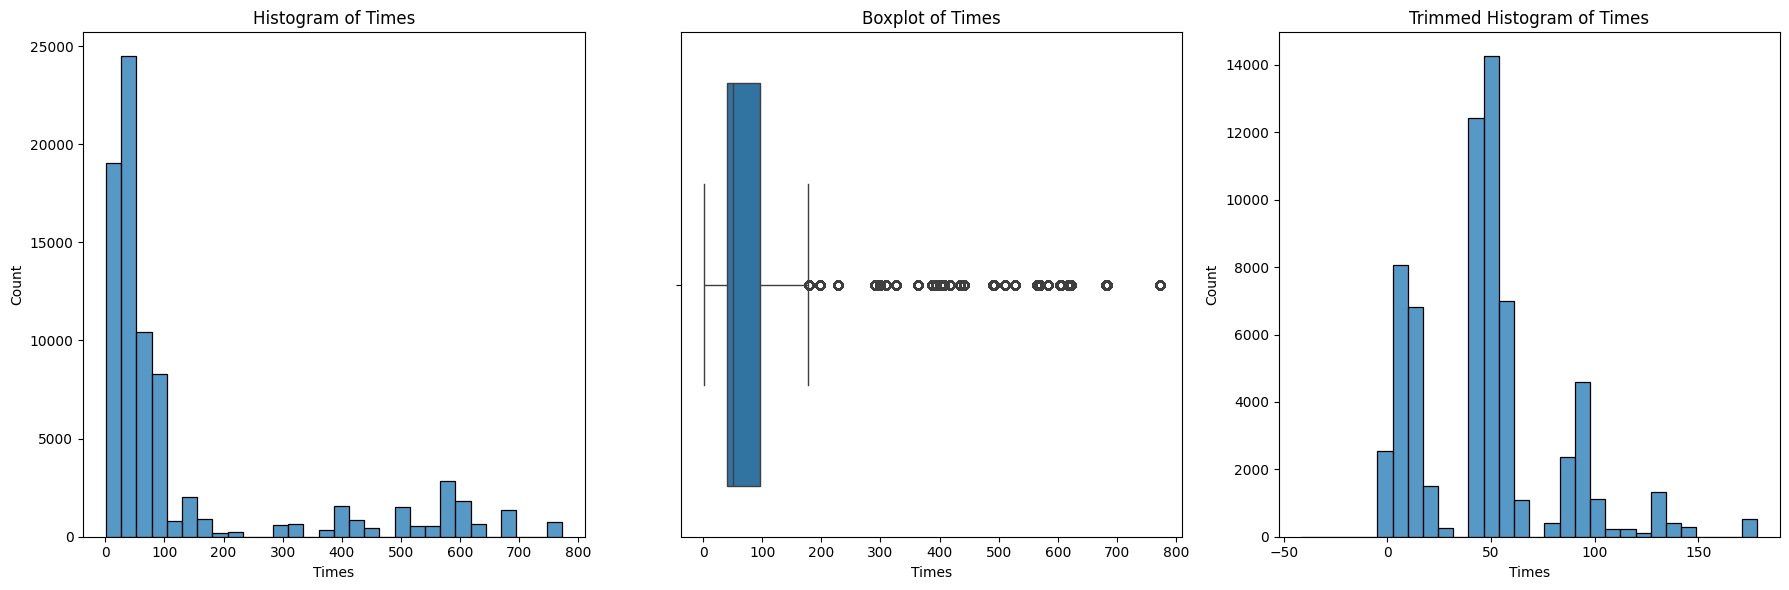

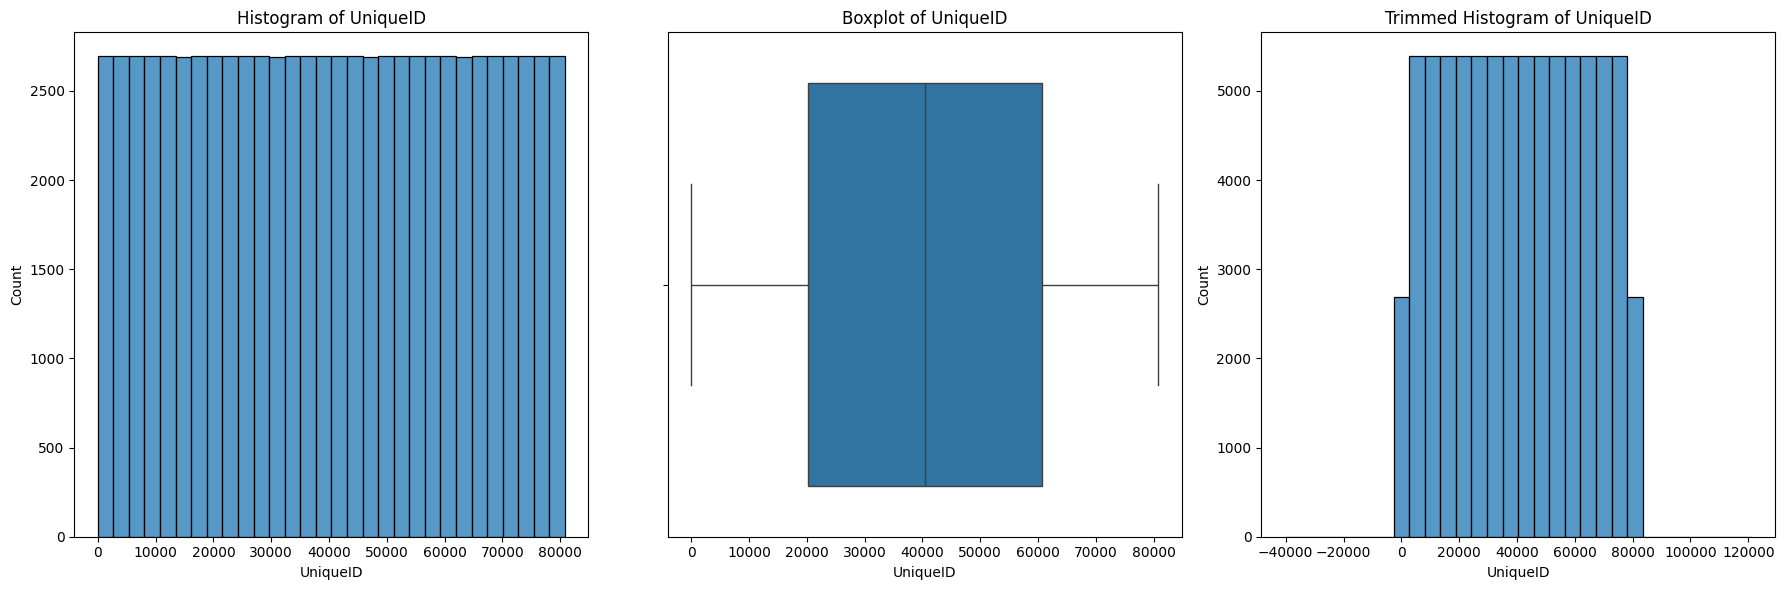

                                            Column          Mean  \
0                                       Unnamed: 0  40407.500000   
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope    113.951954   
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope     43.353231   
3   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1     43.353231   
4   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope     47.828090   
5                              loudness_sma3_amean      0.467605   
6                     spectralFlux_sma3_stddevNorm      1.446313   
7                                 mfcc1_sma3_amean     18.377609   
8                            mfcc1_sma3_stddevNorm      0.905121   
9                                 mfcc2_sma3_amean      9.697731   
10                           mfcc2_sma3_stddevNorm      4.774925   
11                                mfcc3_sma3_amean     12.513296   
12                           mfcc3_sma3_stddevNorm      1.519714   
13                        jitterLocal_sma3nz_ame

In [10]:
from scipy.stats import chi2_contingency

open_smile = pd.read_csv('smile_feature_selected.csv')

def analyze_dataframe(df):
    results = pd.DataFrame(columns=[
        'Column', 'Mean', 'Average', 'Minimum', 'Maximum',
        'Lower outliers', 'Upper outliers', 'Total outliers', 'Outliers(%)'
    ])
    
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        selected_column = df[col]
        Q1 = selected_column.quantile(0.25)
        Q3 = selected_column.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        sns.histplot(selected_column, bins=30, edgecolor='black', ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')
        
        sns.boxplot(x=selected_column, ax=axes[1])
        axes[1].set_title(f'Boxplot of {col}')
        
        sns.histplot(selected_column, bins=30, edgecolor='black',
                     binrange=(lower_bound, upper_bound), ax=axes[2])
        axes[2].set_title(f'Trimmed Histogram of {col}')
        
        plt.tight_layout()
        plt.show()
        
        mean = selected_column.mean()
        minimum = selected_column.min()
        maximum = selected_column.max()
        lower_outliers = selected_column[selected_column < lower_bound].count()
        upper_outliers = selected_column[selected_column > upper_bound].count()
        total_outliers = lower_outliers + upper_outliers
        
        new_row = pd.DataFrame([{
            'Column': col,
            'Mean': mean,
            'Average': mean,
            'Minimum': minimum,
            'Maximum': maximum,
            'Lower outliers': lower_outliers,
            'Upper outliers': upper_outliers,
            'Total outliers': total_outliers,
            'Outliers(%)': (total_outliers / len(selected_column)) * 100,
        }])
        results = pd.concat([results, new_row], ignore_index=True)
    
    return results

results_smile = analyze_dataframe(open_smile)
resultrs_train = analyze_dataframe(full_csv)
print(results_smile)
print(resultrs_train)

A partir d'aquest punt treballem directament amb el training_set.csv pels motius exposats al report

Fusionem variables i fem drop de les que no són necessàries

In [11]:
train_csv['Final_sex'] = train_csv['Sex'].combine_first(train_csv['Target_Sex'])

train_csv['Final_country'] = train_csv['Country'].combine_first(train_csv['Target_Country'])

train_csv.drop(['Target_Sex', 'Target_Country', 'Sex', 'Country'], axis=1, inplace=True)

test_csv['Final_sex'] = test_csv['Sex'].combine_first(test_csv['Target_Sex'])

test_csv['Final_country'] = test_csv['Country'].combine_first(test_csv['Target_Country'])

test_csv.drop(['Target_Sex', 'Target_Country', 'Sex', 'Country'], axis=1, inplace=True)

In [12]:
train_csv.drop(['Source_Sex', 'Source_Country', 'ID', 'Source_ID', 'Target_ID', 'F_path', 'Category'], axis=1, inplace=True)
test_csv.drop(['Source_Sex', 'Source_Country', 'ID', 'Source_ID', 'Target_ID', 'F_path', 'Category'], axis=1, inplace=True)

In [13]:
train_csv.describe()

UniqueID     Realornot
count  17804.000000  17804.000000
mean   48359.654741      0.502078
std    23540.862021      0.500010
min        4.000000      0.000000
25%    29993.250000      0.000000
50%    56484.500000      1.000000
75%    67218.500000      1.000000
max    80815.000000      1.000000

Eliminem una variable duplicada de l'smile

In [14]:
open_smile.drop(['F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1'], axis=1, inplace=True)

Mirem les freqüències de les categòriques 

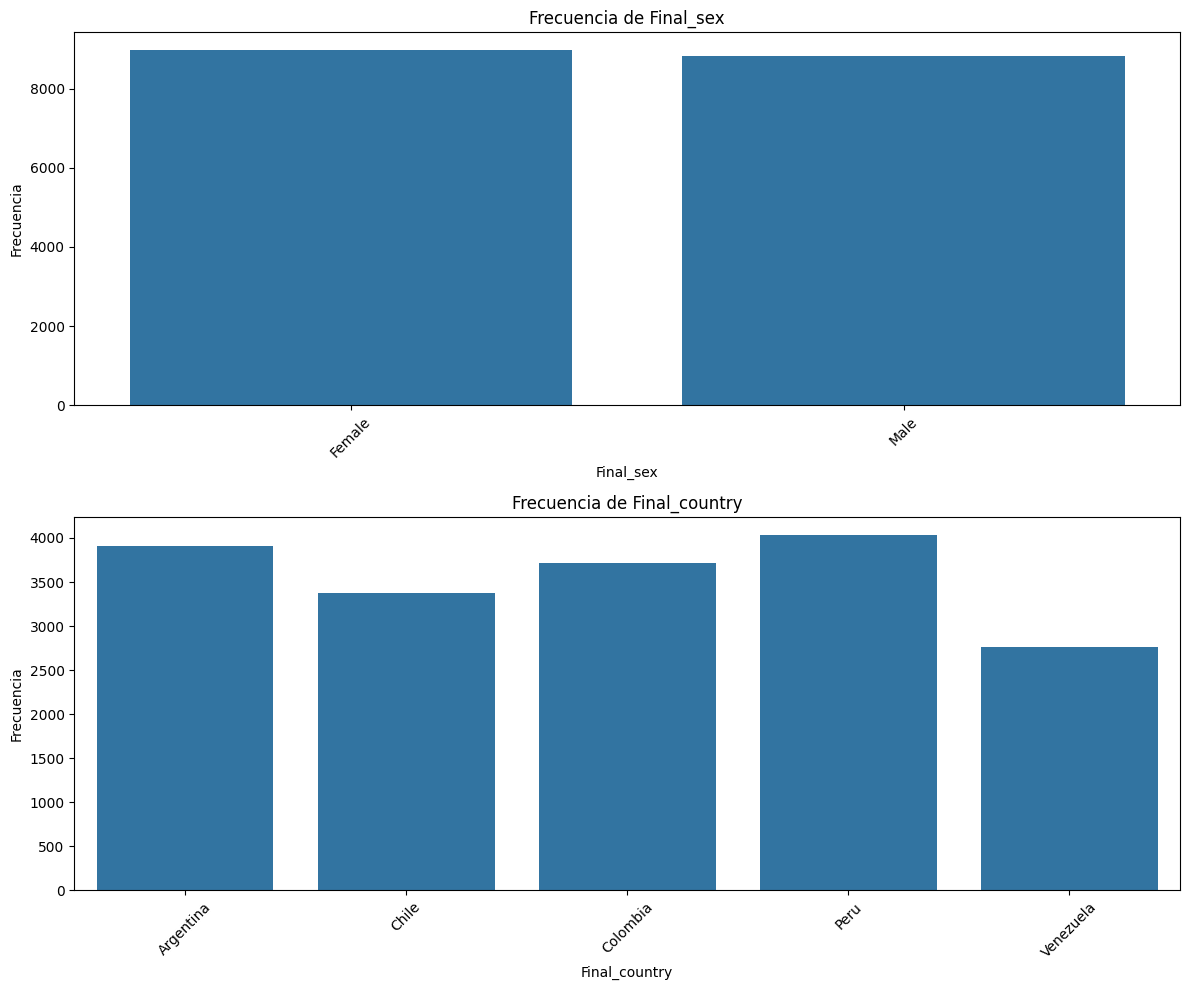

In [15]:
categorical_vars = ['Final_sex', 'Final_country']

fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(12, 5 * len(categorical_vars)))

for i, var in enumerate(categorical_vars):
    sns.countplot(data=train_csv, x=var, ax=axes[i])
    axes[i].set_title(f'Frecuencia de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Mirem si la classe objectiu Realornot està balancejada

Realornot
1    8939
0    8865
Name: count, dtype: int64
Realornot
1    1200
0    1172
Name: count, dtype: int64


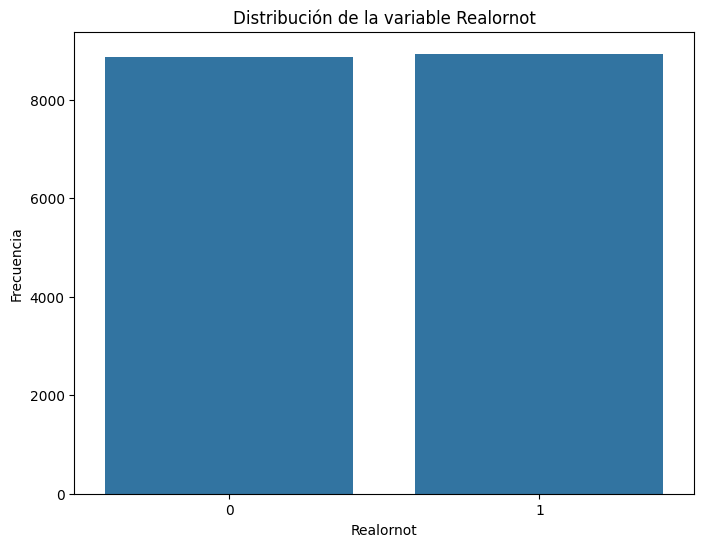

In [16]:
realornot_counts = train_csv['Realornot'].value_counts()
realornot_counts_t = test_csv['Realornot'].value_counts()

print(realornot_counts)
print(realornot_counts_t)

plt.figure(figsize=(8, 6))
sns.countplot(data=train_csv, x='Realornot')
plt.title('Distribución de la variable Realornot')
plt.xlabel('Realornot')
plt.ylabel('Frecuencia')
plt.show()

Com que tractarem els outliers com a missings i els imputarem. Fem el particionat del train en train/val abans d'aquest tractament

In [17]:
from sklearn.model_selection import train_test_split

training_set_p, validation_set = train_test_split(train_csv, test_size=0.2, random_state=42)

training_set_p.to_csv('training_set_p.csv', index=False)
validation_set.to_csv('validation_set.csv', index=False)

data_explore(training_set_p)
data_explore(validation_set)

print(train_csv.shape)
print(training_set_p.shape)
print(validation_set.shape)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (14243, 4)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 14243 entries, 11621 to 15795
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UniqueID       14243 non-null  int64 
 1   Realornot      14243 non-null  int64 
 2   Final_sex      14243 non-null  object
 3   Final_country  14243 non-null  object
dtypes: int64(2), object(2)
memory usage: 556.4+ KB
None
**********************************************************************
STATISTICAL ANALYSIS OF NUMERICAL DATA
**********************************************************************
             count          mean           std  min      25%      50%  \
UniqueID   14243.0  48290.097522  23559.313950  4.0  29973.5  56453.0   
Realornot  14243.0      0.501088      0.500016  0.0      0.0 

Mirem si tenim missings al dataframe d'entrenament:

In [18]:
data_explore(train_csv)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (17804, 4)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17804 entries, 0 to 17803
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UniqueID       17804 non-null  int64 
 1   Realornot      17804 non-null  int64 
 2   Final_sex      17804 non-null  object
 3   Final_country  17804 non-null  object
dtypes: int64(2), object(2)
memory usage: 556.5+ KB
None
**********************************************************************
STATISTICAL ANALYSIS OF NUMERICAL DATA
**********************************************************************
             count          mean           std  min       25%      50%  \
UniqueID   17804.0  48359.654741  23540.862021  4.0  29993.25  56484.5   
Realornot  17804.0      0.502078      0.500010  0.0      0

Normalització de les variables:

Agafem un dataframe copiat sense els valors extrems per poder veure bé la gaussianitat de les varibales ja que els outliers més grans no deformaran la distribució

In [19]:
smile_imputed = open_smile.copy()

columns_to_exclude = ['Unnamed: 0', 'UniqueID']
numeric_columns = smile_imputed.select_dtypes(include=[np.number]).drop(columns=columns_to_exclude, errors='ignore')

for col in numeric_columns.columns:
    lower_threshold = smile_imputed[col].quantile(0.01)
    upper_threshold = smile_imputed[col].quantile(0.99)
    smile_imputed = smile_imputed[(smile_imputed[col] > lower_threshold) & (smile_imputed[col] < upper_threshold)]

print(smile_imputed.shape)
data_explore_n(smile_imputed)

(61675, 15)
DATA EXPLORATION
**********************************************************************
Shape of dataset :  (61675, 15)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 61675 entries, 0 to 80814
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      61675 non-null  int64  
 1   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   61675 non-null  float64
 2   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    61675 non-null  float64
 3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  61675 non-null  float64
 4   loudness_sma3_amean                             61675 non-null  float64
 5   spectralFlux_sma3_stddevNorm                    61675 non-null  float64
 6   mfcc1_sma3_amean                                61675 non-null  float64


Mirem les distribucions de les variables númeriques de opensmile per determinar si son gaussianes

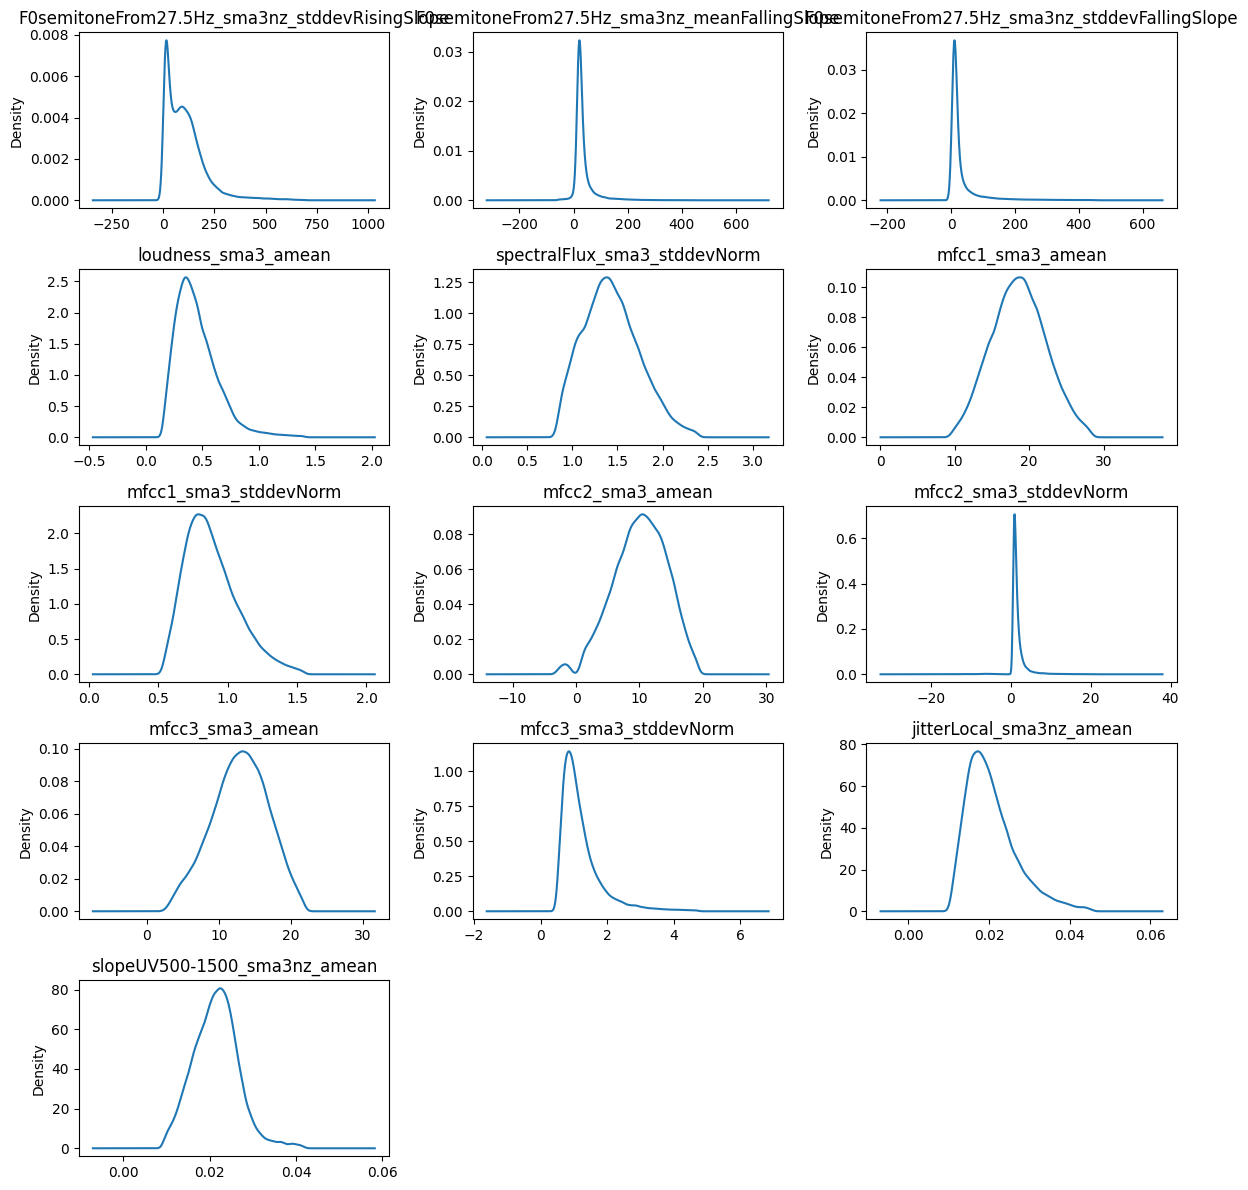

In [20]:
numerical_columns = smile_imputed.select_dtypes(include=[np.number]).columns
columns_to_impute = [col for col in numerical_columns if col not in columns_to_exclude]
# Plot KDE
fig = plt.figure(figsize=(12,12))

num_cols = len(columns_to_impute)
num_rows = (num_cols // 3) + (1 if num_cols % 3 != 0 else 0)

for i, col in enumerate(columns_to_impute):
    ax = fig.add_subplot(num_rows, 3, i+1)
    smile_imputed[col].plot.kde(ax=ax)
    plt.title(col)

fig.tight_layout()
plt.show()

Ho visualitzem

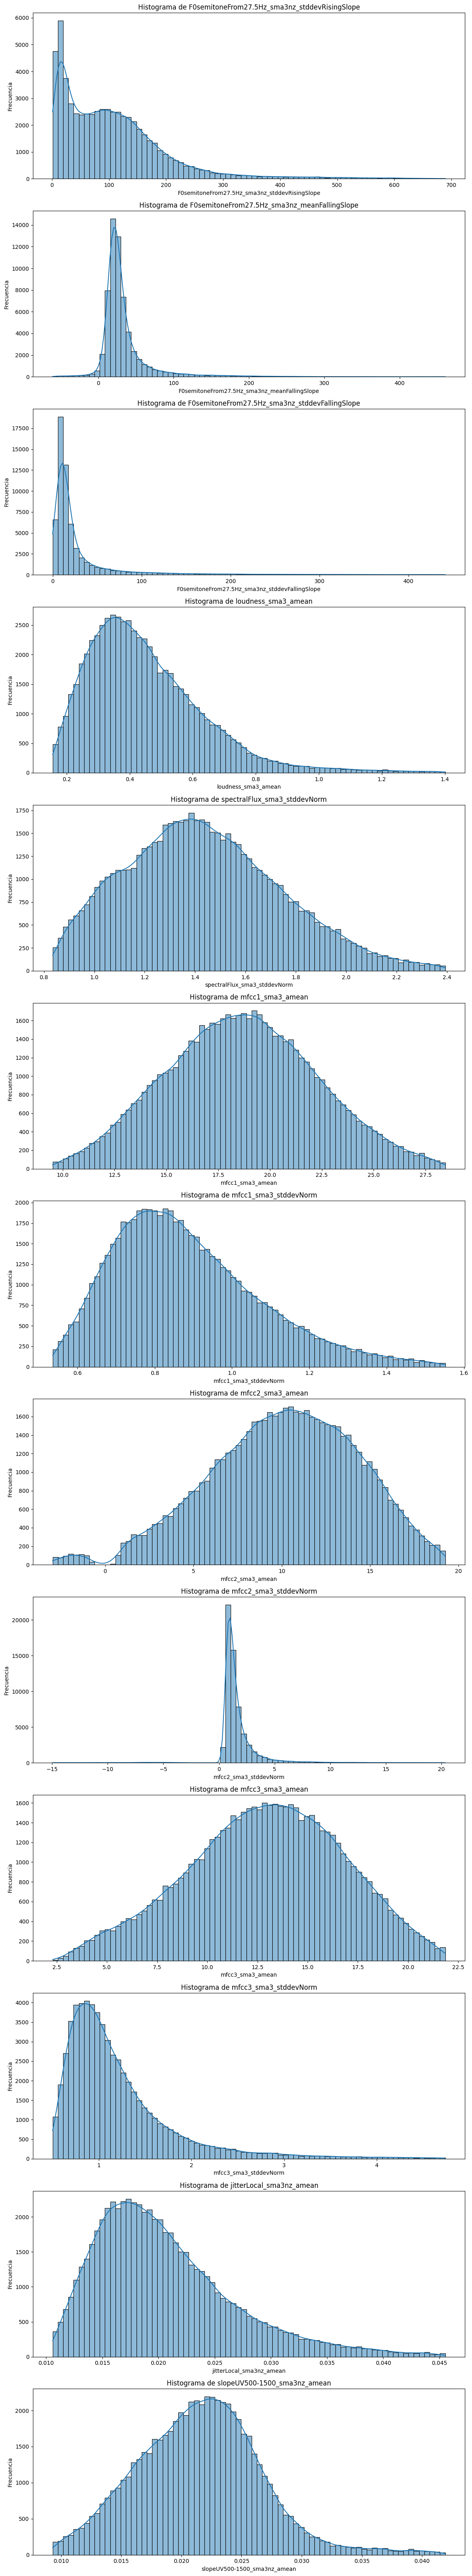

In [21]:
def plot_histograms(df):
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    columns_to_impute = [col for col in numerical_columns if col not in columns_to_exclude]
    
    fig, axes = plt.subplots(len(columns_to_impute), 1, figsize=(12, 5 * len(columns_to_impute)))
    
    for i, col in enumerate(columns_to_impute):
        sns.histplot(df[col], bins=75, kde=True, ax=axes[i])
        axes[i].set_title(f'Histograma de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

plot_histograms(smile_imputed)

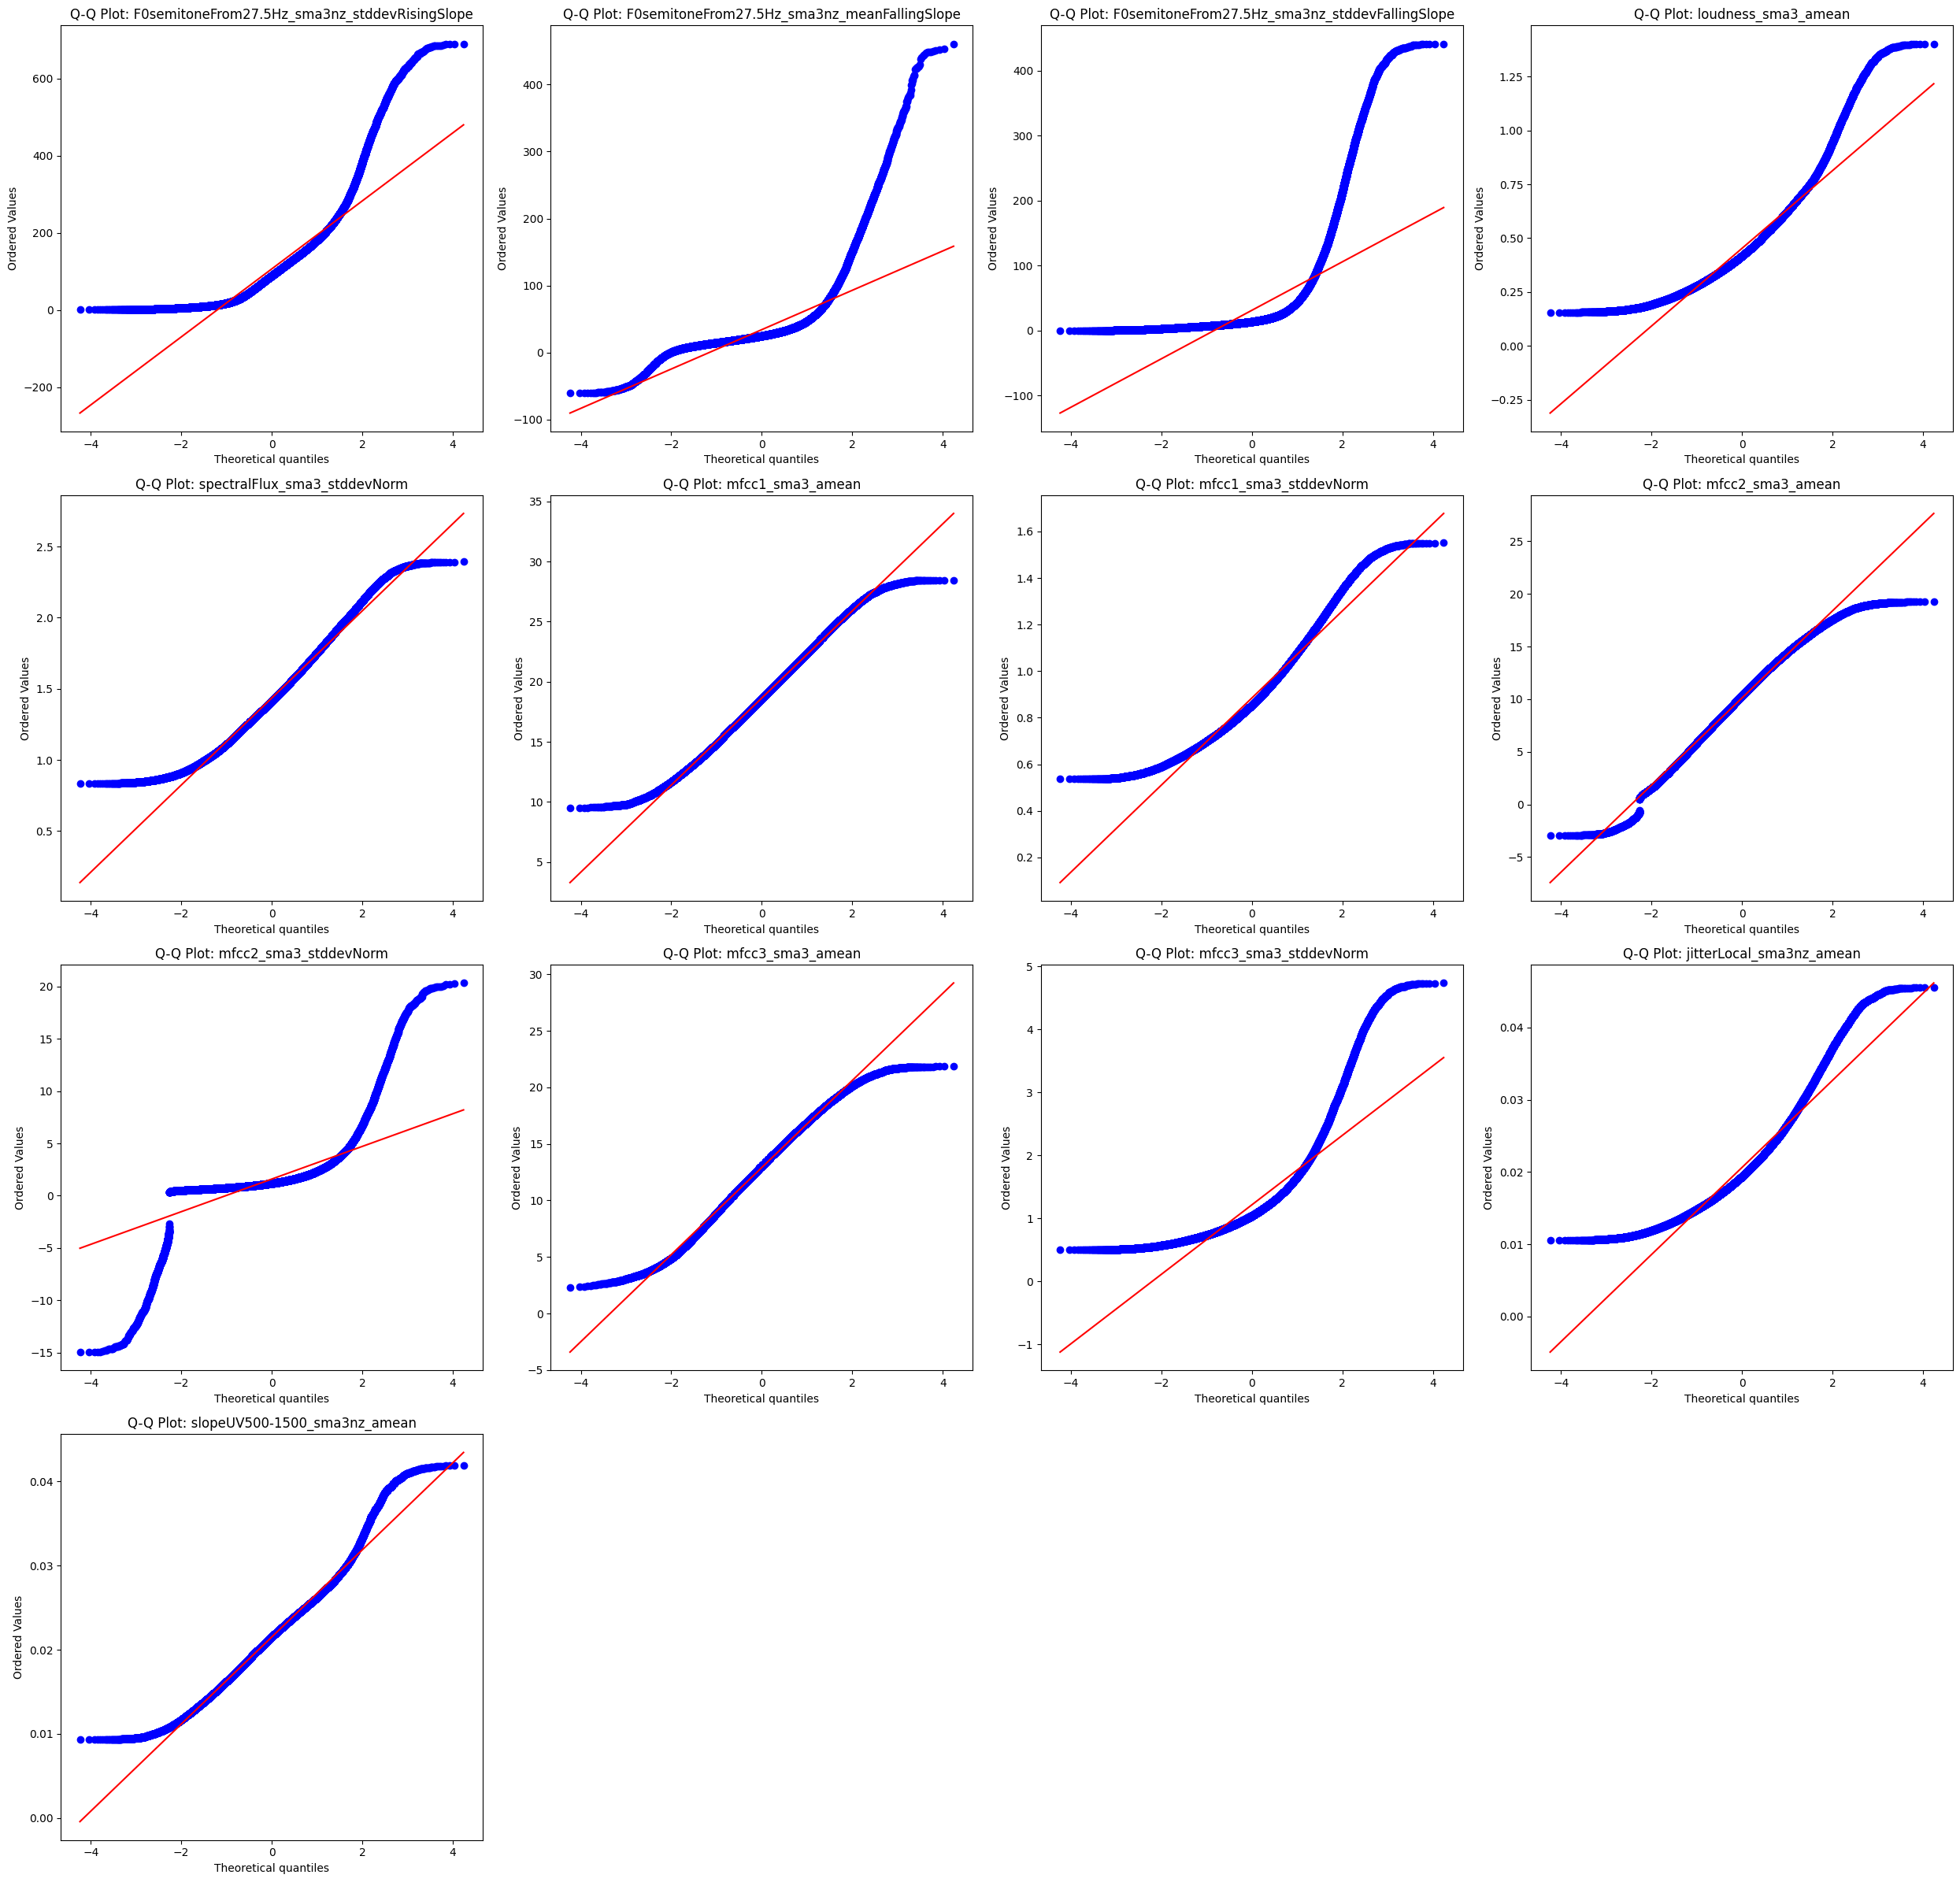

In [22]:
import scipy.stats as stats

def qq_plot(df):
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    columns_to_impute = [col for col in numerical_columns if col not in columns_to_exclude]

    num_vars = len(columns_to_impute)
    rows = (num_vars + 3) // 4 
    fig, axes = plt.subplots(rows, 4, figsize=(25, rows * 6))

    axes = axes.flatten()

    for i, var in enumerate(columns_to_impute):
        stats.probplot(df[var], dist="norm", plot=axes[i])
        axes[i].set_title(f"Q-Q Plot: {var}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

qq_plot(smile_imputed)

Normalització de les variables

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def normalize_features(df):
    df_normalized = df.copy()
    
    f0_features = [
        'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
        'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
        'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope'
    ]
    df_normalized[f0_features] = np.log1p(df[f0_features])
    
    robust_scaler = RobustScaler()
    df_normalized[f0_features] = robust_scaler.fit_transform(df_normalized[f0_features])
    
    standard_features = [
        'loudness_sma3_amean',
        'mfcc1_sma3_amean',
        'mfcc2_sma3_amean',
        'mfcc3_sma3_amean'
    ]
    standard_scaler = StandardScaler()
    df_normalized[standard_features] = standard_scaler.fit_transform(df[standard_features])
    
    normalized_features = [
        'spectralFlux_sma3_stddevNorm',
        'mfcc1_sma3_stddevNorm',
        'mfcc2_sma3_stddevNorm',
        'mfcc3_sma3_stddevNorm'
    ]
    
    minmax_features = [
        'jitterLocal_sma3nz_amean',
        'slopeUV500-1500_sma3nz_amean'
    ]
    minmax_scaler = MinMaxScaler()
    df_normalized[minmax_features] = minmax_scaler.fit_transform(df[minmax_features])
    
    return df_normalized

df_normalized = normalize_features(open_smile)
df_normalized.to_csv('smile_feature_selected_normalized.csv', index=False)

Un cop normalitzades les variables, utilitzem IQR per calcular els outliers de cada variable numèrica

In [24]:
def calculate_outliers_percentage(df):
    outliers_info = pd.DataFrame(columns=['Variable', 'Outliers (%)'])
    
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        lower_outliers = df[df[col] < lower_bound].shape[0]
        upper_outliers = df[df[col] > upper_bound].shape[0]
        total_outliers = lower_outliers + upper_outliers
        outliers_percentage = (total_outliers / df.shape[0]) * 100

        outliers_info = pd.concat([outliers_info, pd.DataFrame([{
            'Variable': col,
            'Outliers (%)': outliers_percentage
        }])], ignore_index=True)
    
    return outliers_info

open_smile = pd.read_csv('smile_feature_selected_normalized.csv')
outliers_info_t = calculate_outliers_percentage(open_smile)
print(outliers_info_t)

                                          Variable  Outliers (%)
0                                       Unnamed: 0      0.000000
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope      1.199020
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope      7.545536
3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope      8.420362
4                              loudness_sma3_amean      3.556226
5                     spectralFlux_sma3_stddevNorm      1.383389
6                                 mfcc1_sma3_amean      1.053009
7                            mfcc1_sma3_stddevNorm      3.292665
8                                 mfcc2_sma3_amean      1.067858
9                            mfcc2_sma3_stddevNorm     13.409473
10                                mfcc3_sma3_amean      1.085181
11                           mfcc3_sma3_stddevNorm      8.598545
12                        jitterLocal_sma3nz_amean      4.040042
13                    slopeUV500-1500_sma3nz_amean      3.050139
14                       

In [25]:
outliers_info_train = calculate_outliers_percentage(training_set_p)
print(outliers_info_train)

    Variable  Outliers (%)
0   UniqueID           0.0
1  Realornot           0.0


Tal i com hem deixat el train no tenim missings, en el open smile tampoc hi ha missings. Tot i així tractarem els outliers com a missings, marcant-los com a NA i imputant-los utilitzant KNN

Fem IQR finalment per marcar outliers com a NA

In [26]:
def filter_outliers_iqr(df):
    filtered_df = df.copy()
    for col in df.select_dtypes(include='number').columns:
        if col not in ['Unnamed: 0', 'UniqueID']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            filtered_df[col] = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound), other=pd.NA)
    return filtered_df

smile = filter_outliers_iqr(open_smile)

outliers_info = calculate_outliers_percentage(smile)
print(f"Original dataset shape: {open_smile.shape}")
print(f"Filtered dataset shape: {smile.shape}")
print(outliers_info)

Original dataset shape: (80816, 15)
Filtered dataset shape: (80816, 15)
                                          Variable  Outliers (%)
0                                       Unnamed: 0      0.000000
1    F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope      0.159622
2     F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope      2.218620
3   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope      3.452287
4                              loudness_sma3_amean      0.540735
5                     spectralFlux_sma3_stddevNorm      0.173233
6                                 mfcc1_sma3_amean      0.070531
7                            mfcc1_sma3_stddevNorm      0.696644
8                                 mfcc2_sma3_amean      0.174470
9                            mfcc2_sma3_stddevNorm      3.468373
10                                mfcc3_sma3_amean      0.112601
11                           mfcc3_sma3_stddevNorm      2.556424
12                        jitterLocal_sma3nz_amean      1.048060
13                

Imputem els NA utilitzant KNN

In [27]:
from sklearn.impute import KNNImputer

columns_to_exclude = ['Unnamed: 0', 'UniqueID']

numeric_columns = smile.select_dtypes(include=['int64', 'float64']).columns
columns_to_impute = [col for col in numeric_columns if col not in columns_to_exclude]

knn_imputer = KNNImputer(n_neighbors=3)
smile[columns_to_impute] = knn_imputer.fit_transform(smile[columns_to_impute])

print("Number of remaining NaN values:", smile[columns_to_impute].isna().sum().sum())

smile.to_csv('smile_final.csv', index=False)

Number of remaining NaN values: 0


Visualitzem el després d'imputar els outliers

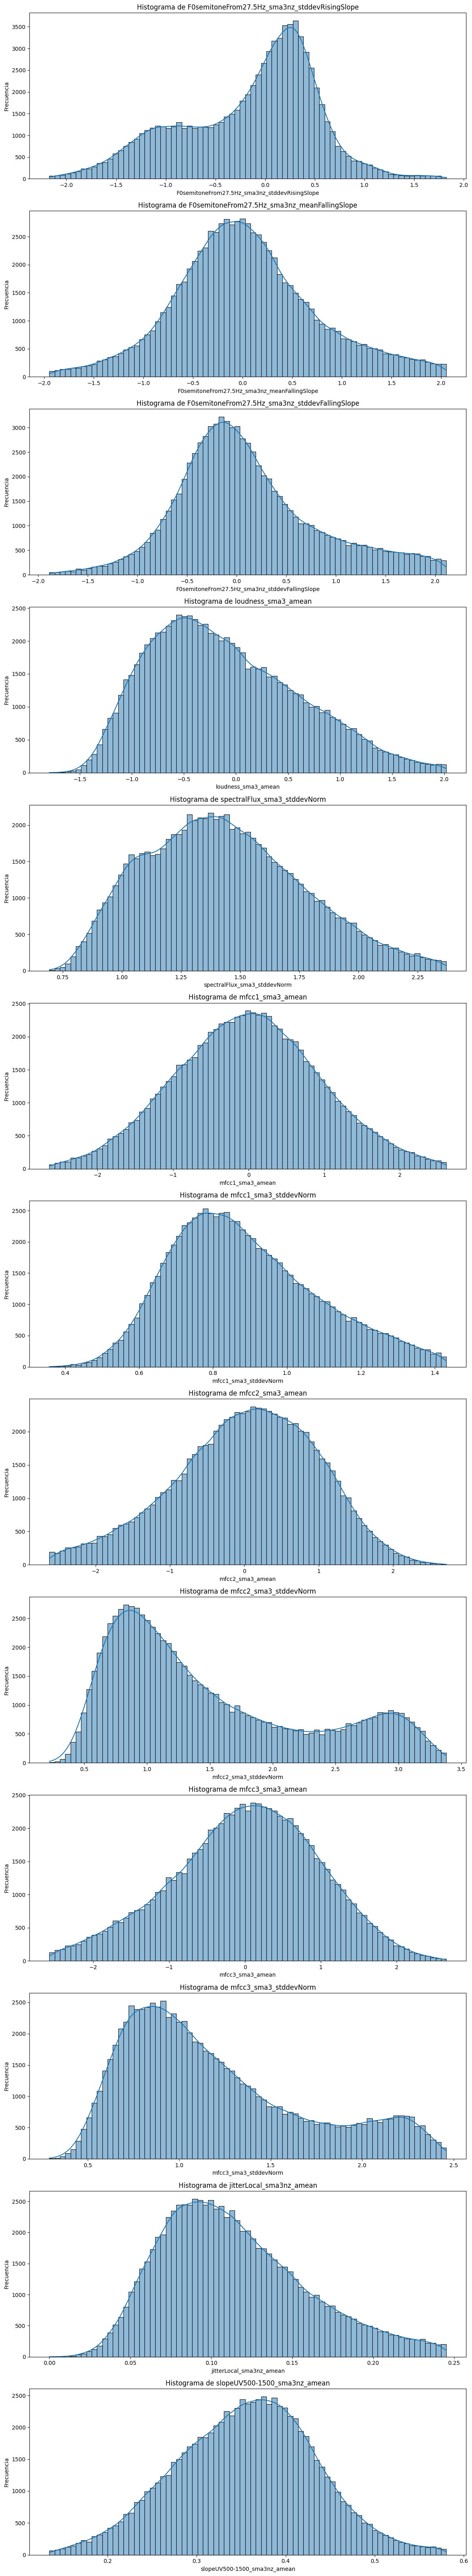

In [28]:
plot_histograms(smile)

Un cop tractats els outliers, podem apreciar millor com han quedat les variables després de la normalització

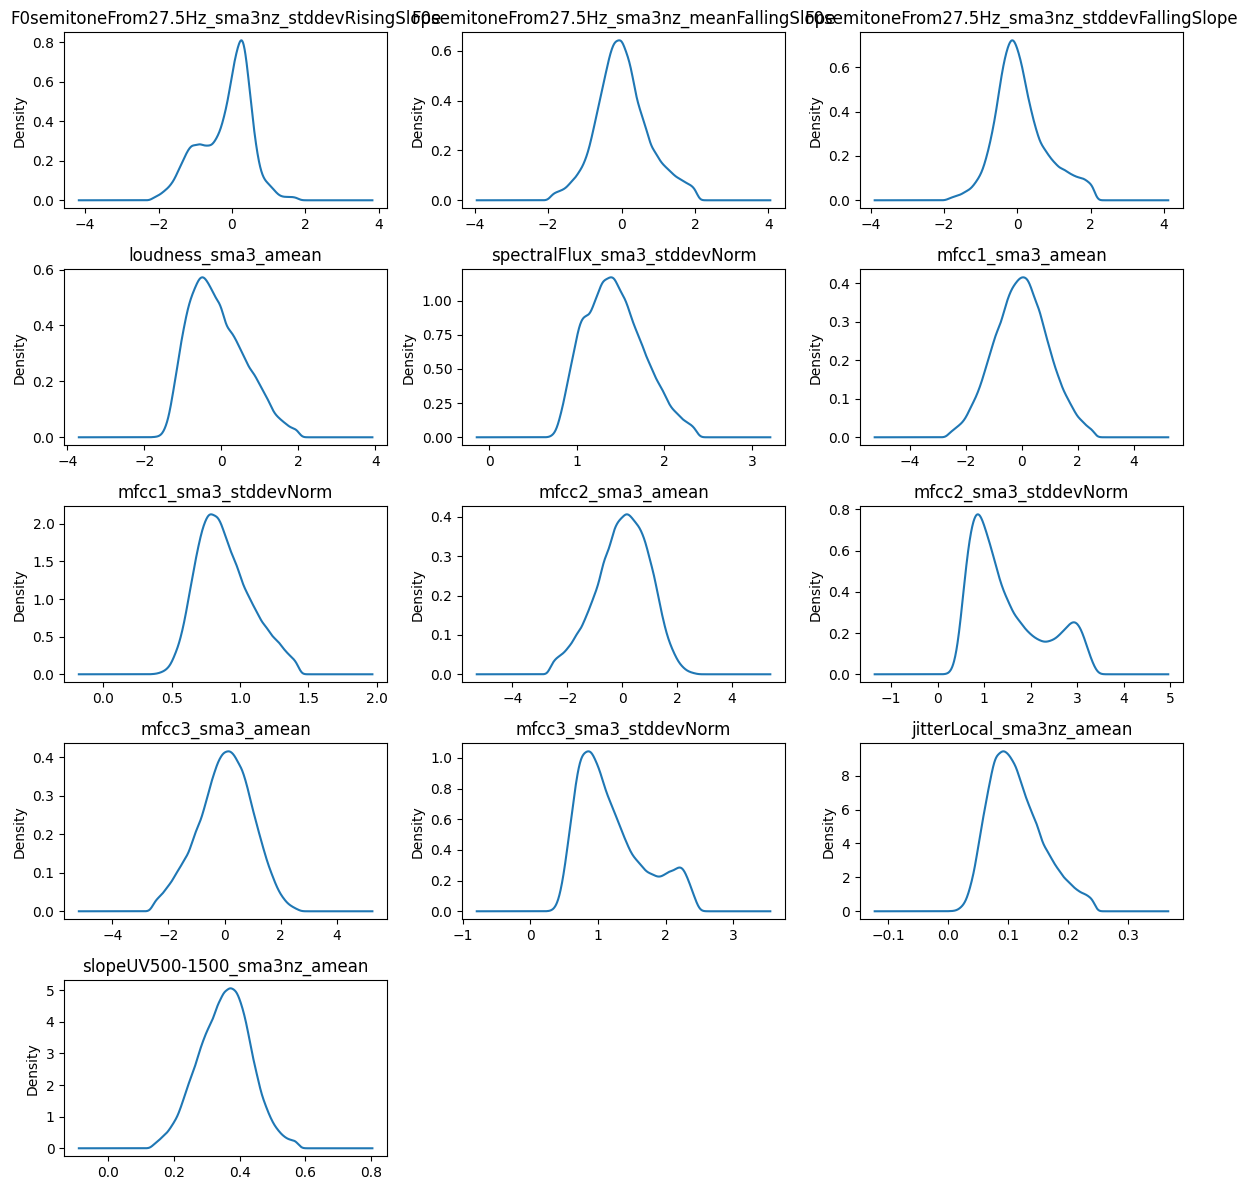

In [29]:
numerical_columns = smile.select_dtypes(include=[np.number]).columns
columns_to_impute = [col for col in numerical_columns if col not in columns_to_exclude]
# Plot KDE
fig = plt.figure(figsize=(12,12))

num_cols = len(columns_to_impute)
num_rows = (num_cols // 3) + (1 if num_cols % 3 != 0 else 0)

for i, col in enumerate(columns_to_impute):
    ax = fig.add_subplot(num_rows, 3, i+1)
    smile[col].plot.kde(ax=ax)
    plt.title(col)

fig.tight_layout()
plt.show()

Tot això ho hem fet abans del merge per no afegir soroll a la imputació amb KNN

Fem el merge del train i el test amb el smile

In [30]:
smile_features = pd.read_csv('smile_final.csv')

train_merged = pd.merge(training_set_p, smile_features, on='UniqueID', how='left')

test_merged = pd.merge(test_csv, smile_features, on='UniqueID', how='left')

val_merged = pd.merge(validation_set, smile_features, on='UniqueID', how='left')

data_explore(train_merged)
data_explore(test_merged)
data_explore(val_merged)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (14243, 18)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14243 entries, 0 to 14242
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   UniqueID                                        14243 non-null  int64  
 1   Realornot                                       14243 non-null  int64  
 2   Final_sex                                       14243 non-null  object 
 3   Final_country                                   14243 non-null  object 
 4   Unnamed: 0                                      14243 non-null  int64  
 5   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope   14243 non-null  float64
 6   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope    14243 non-null  float64
 7   F0

Recodificació de variables:
one hot encoding per final_country i un map per final_sex

Ho repliquem al validation i al test

In [31]:
train_set_encoded = pd.get_dummies(train_merged, columns=['Final_country'])
train_set_encoded['Final_sex'] = train_set_encoded['Final_sex'].map({'Male': 0, 'Female': 1})

test_set_encoded = pd.get_dummies(test_merged, columns=['Final_country'])
test_set_encoded['Final_sex'] = test_set_encoded['Final_sex'].map({'Male': 0, 'Female': 1})

val_set_encoded = pd.get_dummies(val_merged, columns=['Final_country'])
val_set_encoded['Final_sex'] = val_set_encoded['Final_sex'].map({'Male': 0, 'Female': 1})

cols_to_convert = [col for col in train_set_encoded.columns if col.startswith('Final_country_')]

for col in cols_to_convert:
    train_set_encoded[col] = train_set_encoded[col].astype(int)
    test_set_encoded[col] = test_set_encoded[col].astype(int)
    val_set_encoded[col] = val_set_encoded[col].astype(int)

2) PREPARACIÓ DE VARIABLES

Mirem com estan relacionades las categoriques amb la variable objectiu:

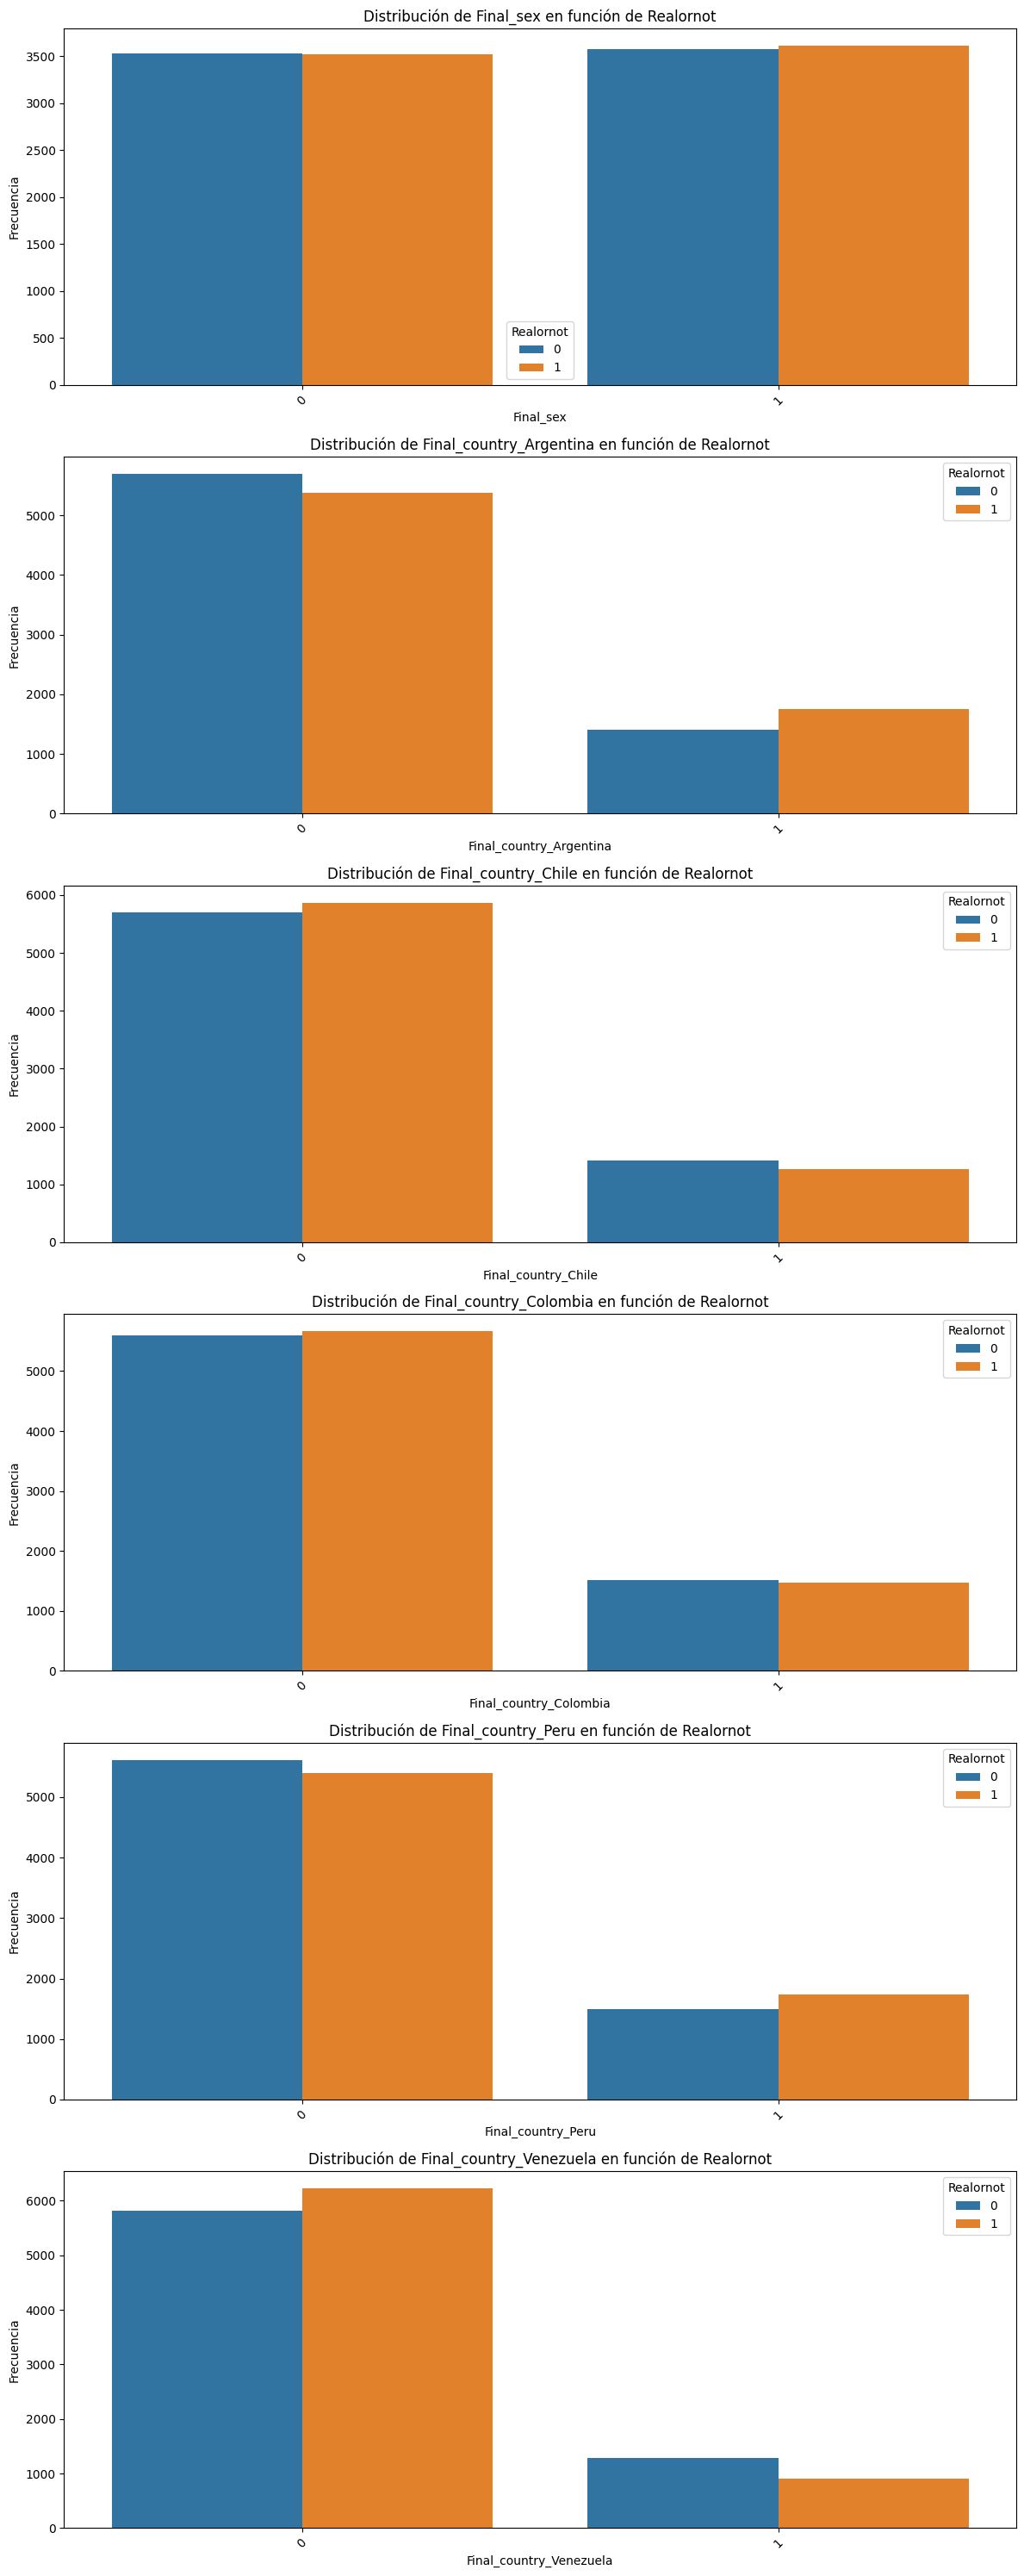

In [32]:
categorical_vars = ['Final_sex', 'Final_country_Argentina', 'Final_country_Chile', 'Final_country_Colombia', 'Final_country_Peru', 'Final_country_Venezuela']

fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(12, 5 * len(categorical_vars)))

for i, var in enumerate(categorical_vars):
    sns.countplot(data=train_set_encoded, x=var, hue='Realornot', ax=axes[i])
    axes[i].set_title(f'Distribución de {var} en función de Realornot')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Farem la correlacio i el t test per veure quines variables del smile descartem del train (ho mirem només sobre el smile perquè aquestes són les únques variables continues del train):

Mirem com correlacionen les variables del smile csv amb la variable objectiu. No ho fem per seleccionar, ho fem per descartar

In [33]:
smile_merged = pd.merge(smile, train_set_encoded[['UniqueID', 'Realornot']], on='UniqueID', how='left')

In [34]:
smile_merged.dropna(subset=['Realornot'], inplace=True)

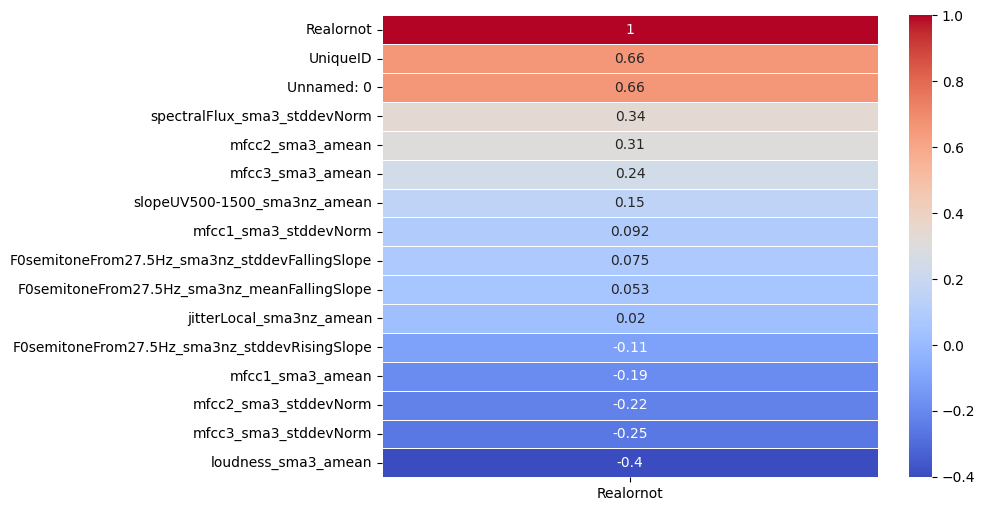

In [35]:
correlation_matrix = smile_merged.corr()

correlation_with_realornot = correlation_matrix[['Realornot']].sort_values(by='Realornot', ascending=False)

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_with_realornot, annot=True, cmap='coolwarm', linewidths=0.5)

plt.show()

També mirem el mapa sencer de correlacions entre variables numèriques

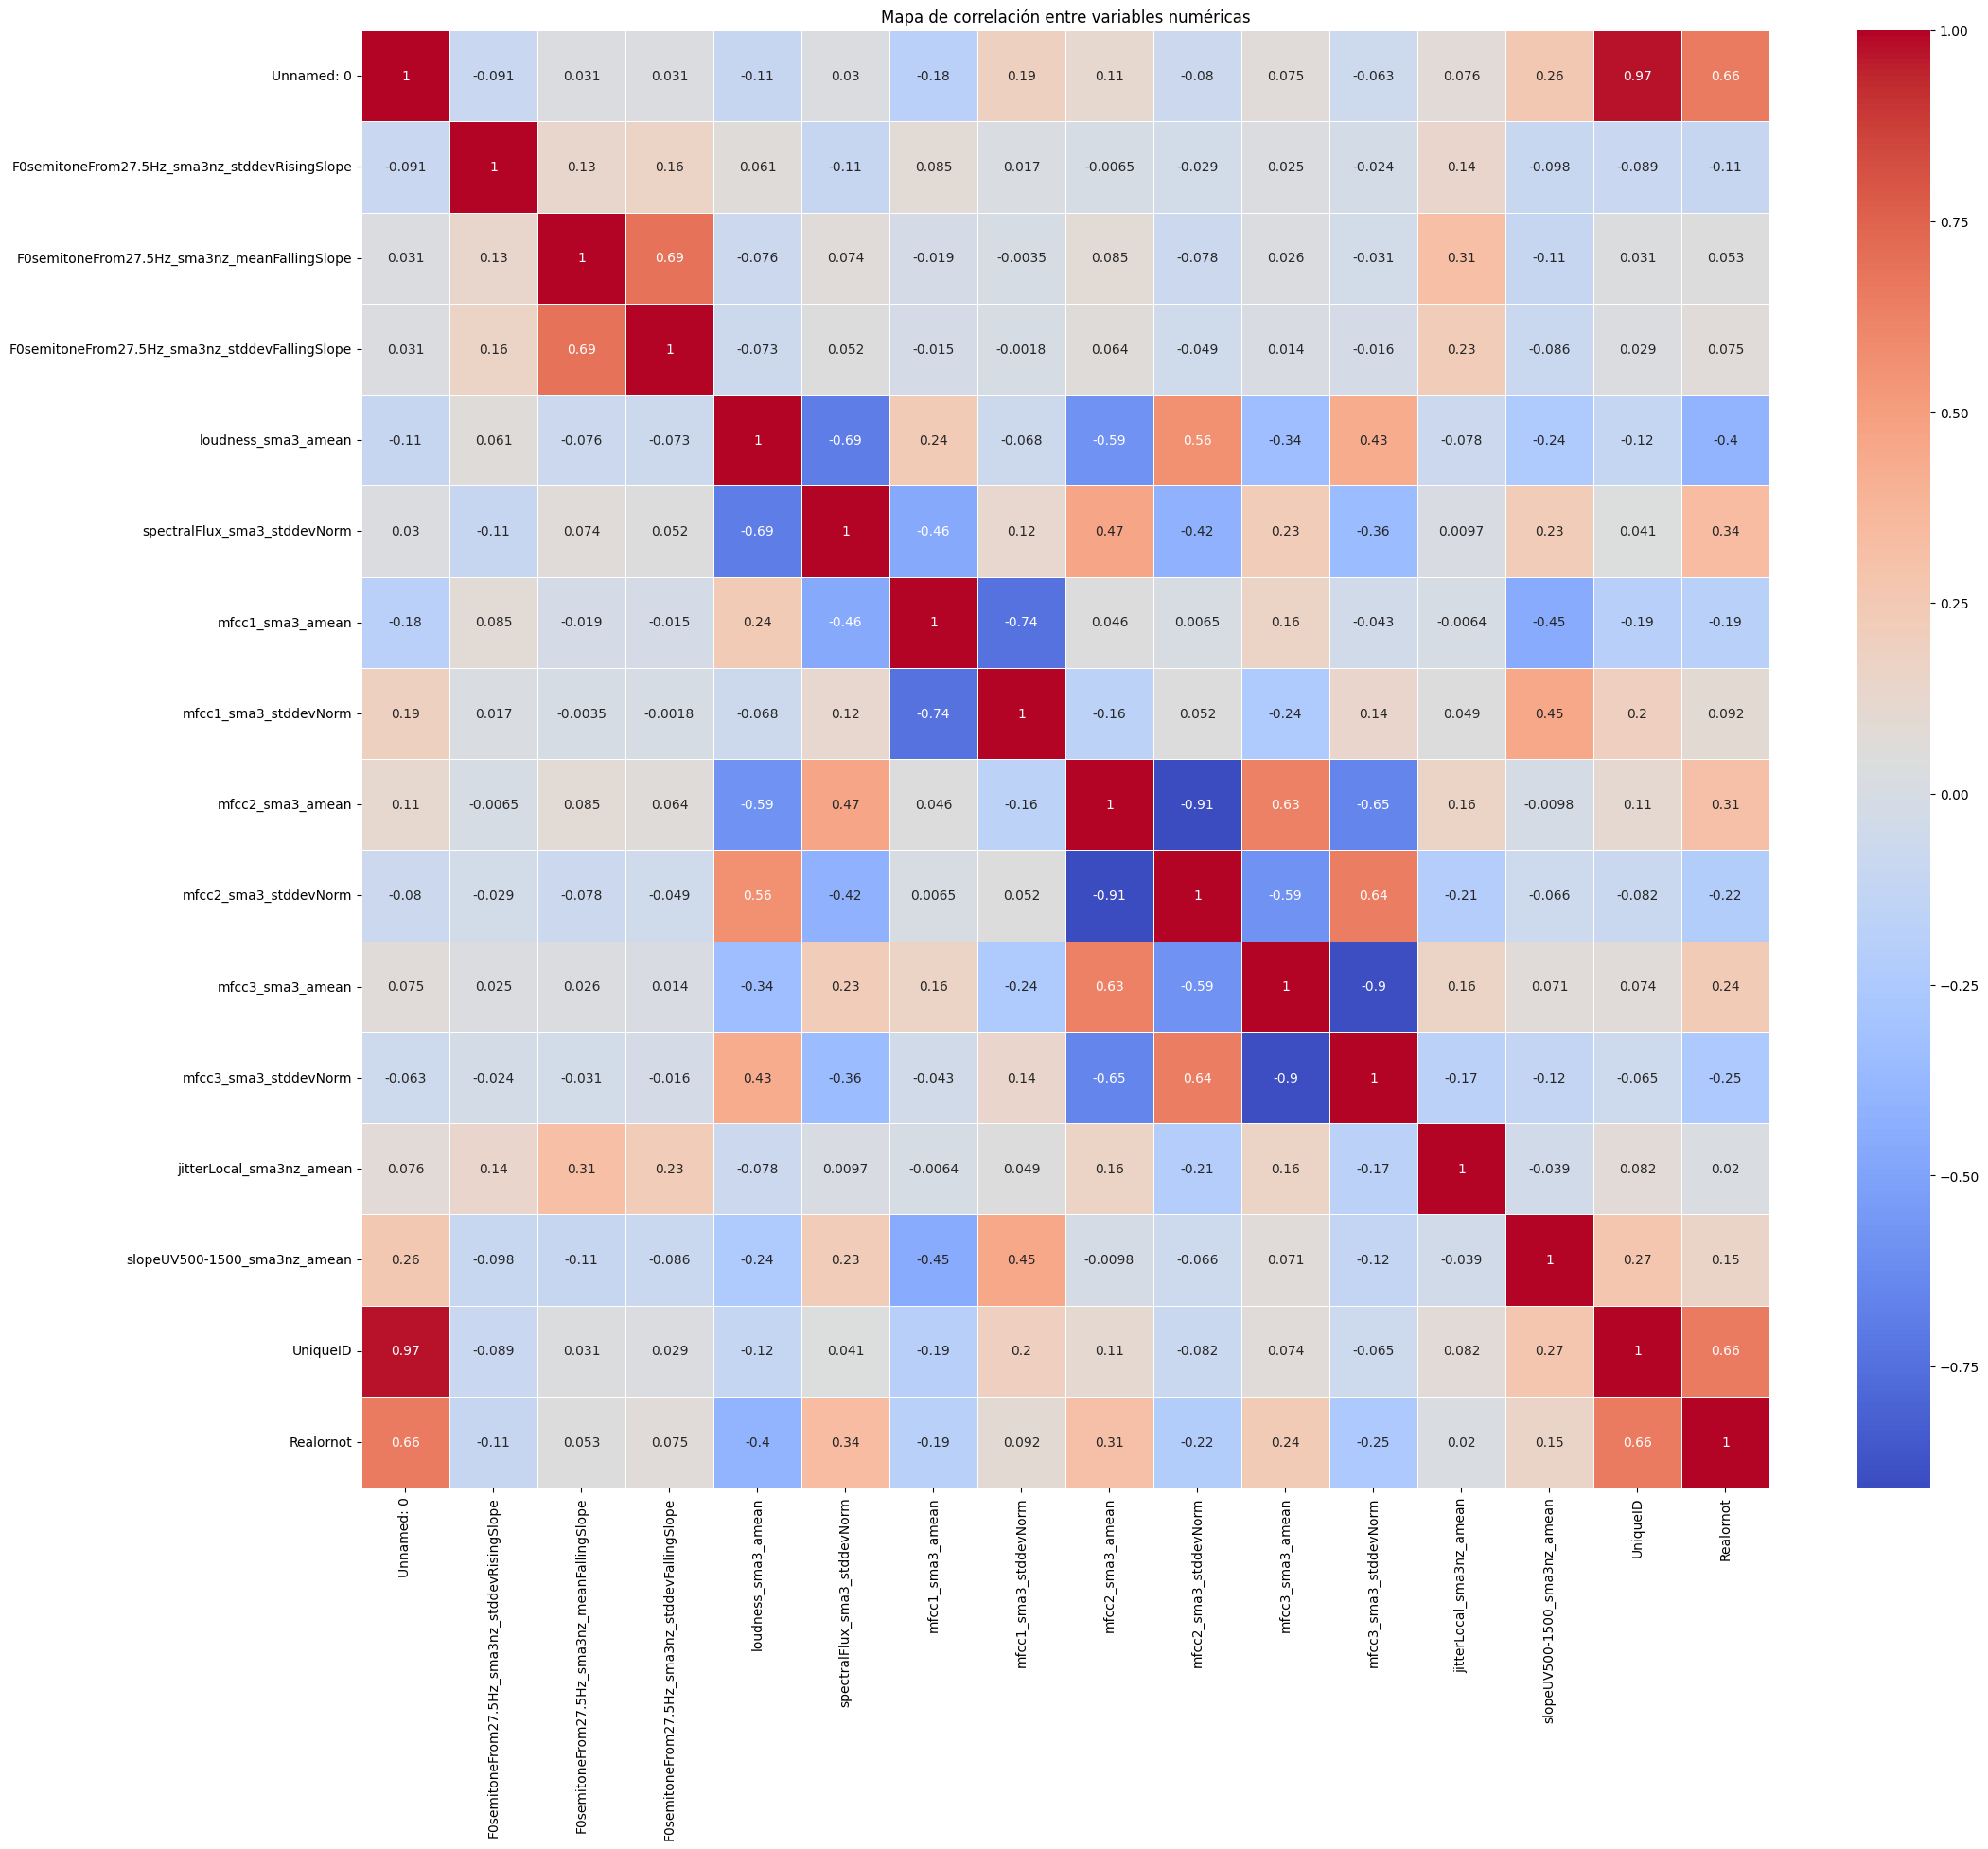

In [36]:
numerical_columns = smile_merged.select_dtypes(include=[np.number]).columns

correlation_matrix = smile_merged[numerical_columns].corr()

plt.figure(figsize=(24, 20))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Mapa de correlación entre variables numéricas')
plt.show()

No podem fer un t test perquè al tenir tantes dades és molt possible que totes ens surtin significatives

doncs, descartem les variables amb correlacions entre 0.1 i -0.1 (que són les que correlacionen poc amb la variable objectiu) i tambe descartem algunes variables que tenen una parella amb la que estan altament correlacionades (de la parella descartem la que menys expliqui Realornot) i ho repliqeum al test i al val. PD: per descartar hem fet servir les correlacions i no el t-test. Tampoc incluim UniqueID ja que seria un greu error conservarla en els datasets de train, test o val

In [37]:
columns_to_drop = ['F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 
                   'jitterLocal_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_stddevNorm',  'mfcc1_sma3_stddevNorm', 'Unnamed: 0', 'UniqueID']

train_set_encoded.drop(columns=columns_to_drop, inplace=True)
test_set_encoded.drop(columns=columns_to_drop, inplace=True)
val_set_encoded.drop(columns=columns_to_drop, inplace=True)

train_set_encoded.to_csv('training.csv', index=False)
test_set_encoded.to_csv('test.csv', index=False)
val_set_encoded.to_csv('val.csv', index=False)

PCA, no incluim les variables processades amb one hot enconding

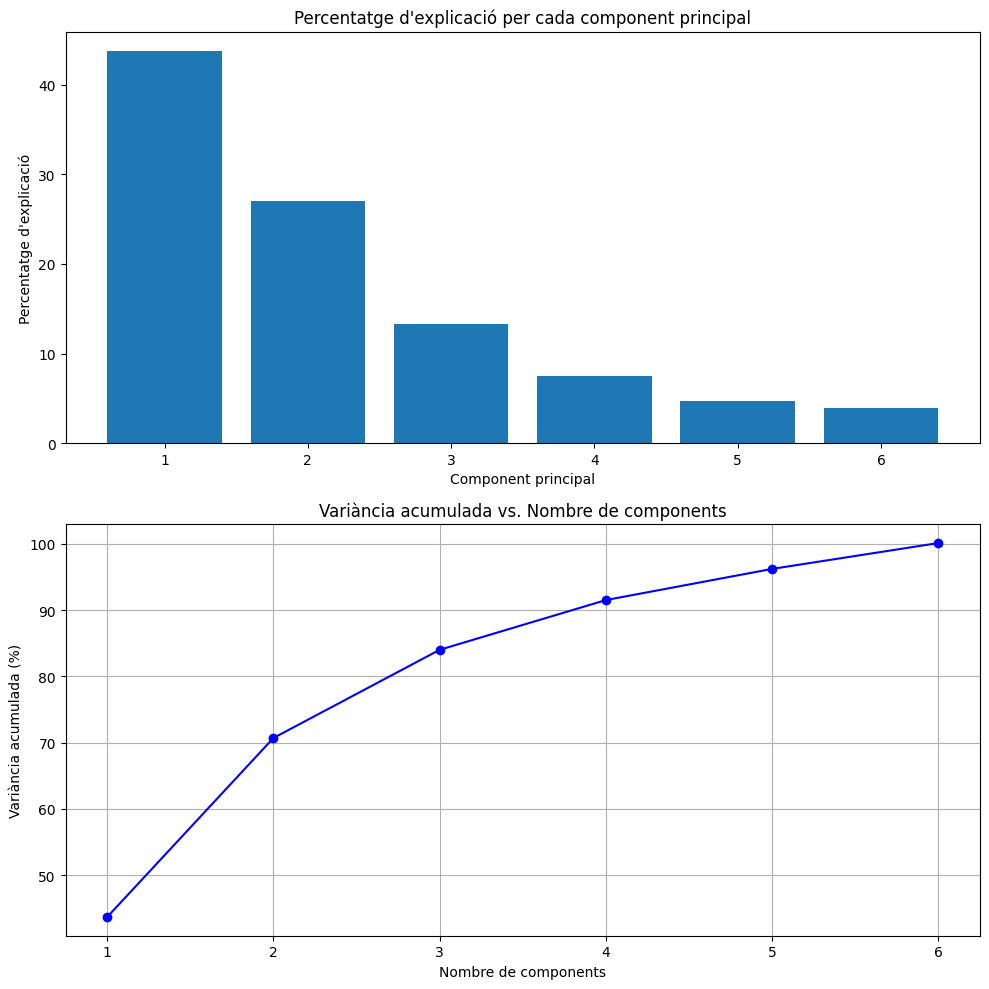


Varianza explicada por componente:
PC1: 43.7%
PC2: 27.0%
PC3: 13.3%
PC4: 7.5%
PC5: 4.7%
PC6: 3.9%

Varianza acumulada:
PC1-PC1: 43.7%
PC1-PC2: 70.7%
PC1-PC3: 84.0%
PC1-PC4: 91.5%
PC1-PC5: 96.2%
PC1-PC6: 100.10000000000001%


In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

training_df = pd.read_csv('training.csv')

numeric_columns = ['loudness_sma3_amean','spectralFlux_sma3_stddevNorm','mfcc1_sma3_amean','mfcc2_sma3_amean',
                   'mfcc3_sma3_amean','slopeUV500-1500_sma3nz_amean']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(training_df[numeric_columns])

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
cum_var = np.cumsum(per_var)
labels = [str(x) for x in range(1, len(per_var) + 1)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
ax1.set_ylabel('Percentatge d\'explicació')
ax1.set_xlabel('Component principal')
ax1.set_title('Percentatge d\'explicació per cada component principal')

ax2.plot(range(1, len(cum_var) + 1), cum_var, 'bo-')
ax2.set_ylabel('Variància acumulada (%)')
ax2.set_xlabel('Nombre de components')
ax2.set_title('Variància acumulada vs. Nombre de components')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nVarianza explicada por componente:")
for i, var in enumerate(per_var, 1):
    print(f"PC{i}: {var}%")
print("\nVarianza acumulada:")
for i, cum in enumerate(cum_var, 1):
    print(f"PC1-PC{i}: {cum}%")

3. DEFINICIÓ DE MODELS

Definim una funció per evaluar el model utiltizant la precision, el recall, l'accuracy el f1 score i la curva ROC

In [39]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true, y_pred, y_prob, dataset_name="Dataset"):
    print(f"\nEvaluation Metrics for {dataset_name}:")
    print(classification_report(y_true, y_pred))

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name='Model'):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()

Per trobar la millor combinació d'hiperparàmetres farem servir la tècnica de GridSearchCV de la llibreria sklearn per maximitzar el f1 score:

PRIMER MODEL: KNN

Trobar la millor combinació d'hiperparàmetres per KNN i evaluar el model

In [40]:
from sklearn.model_selection import GridSearchCV


train_df = pd.read_csv('training.csv')
val_df = pd.read_csv('val.csv')

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 8, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='precision', cv=10, n_jobs=-1)

X_train = train_df.drop(columns=['Realornot'])
y_train = train_df['Realornot']

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

mean_precision = grid_search.cv_results_['mean_test_score'].mean()
std_precision = grid_search.cv_results_['std_test_score'].mean()
print(f"Mean precision: {mean_precision:.4f} (+/- {std_precision:.4f})")

Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}
Mean precision: 0.7641 (+/- 0.0109)


Validem el model


Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      7106
           1       0.84      0.88      0.86      7137

    accuracy                           0.85     14243
   macro avg       0.86      0.85      0.85     14243
weighted avg       0.86      0.85      0.85     14243



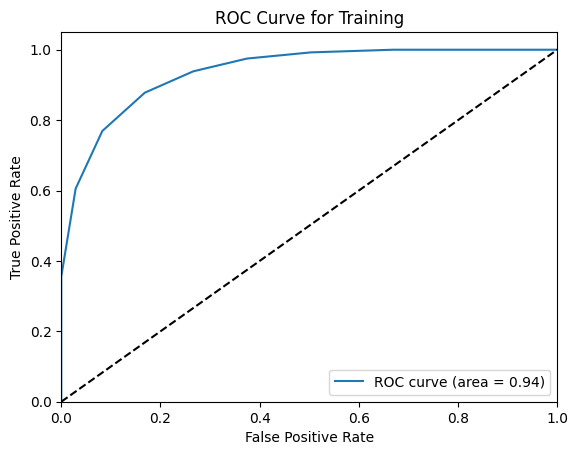

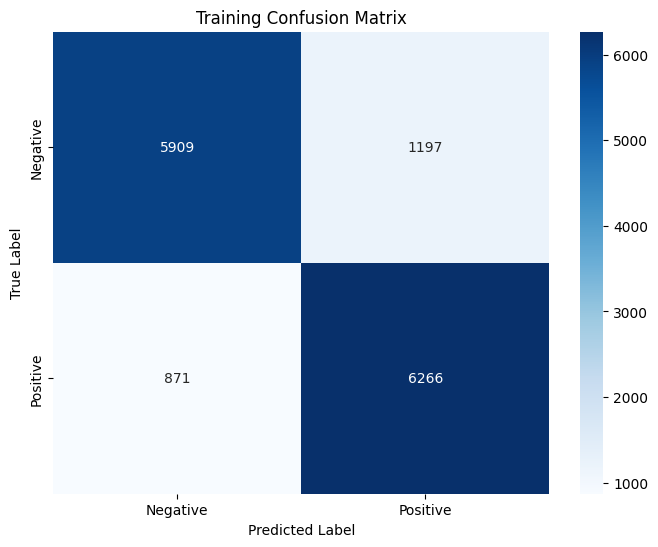


Evaluation Metrics for Validation:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1759
           1       0.81      0.85      0.83      1802

    accuracy                           0.82      3561
   macro avg       0.82      0.82      0.82      3561
weighted avg       0.82      0.82      0.82      3561



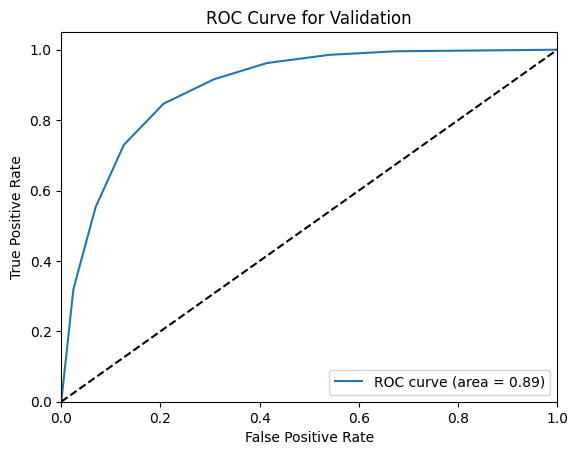

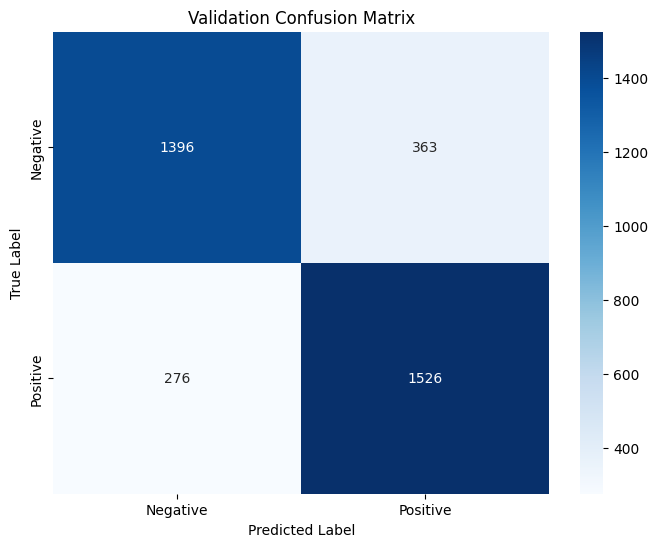

In [41]:
best_knn = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'], 
    metric=best_params['metric']
)

best_knn.fit(X_train, y_train)

X_val = val_df.drop(columns=['Realornot'])
y_val = val_df['Realornot']

train_pred = best_knn.predict(X_train)
train_prob = best_knn.predict_proba(X_train)[:, 1]
val_pred = best_knn.predict(X_val)
val_prob = best_knn.predict_proba(X_val)[:, 1]

evaluate_model(y_train, train_pred, train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, train_pred, model_name='Training')
evaluate_model(y_val, val_pred, val_prob, dataset_name="Validation")
plot_confusion_matrix(y_val, val_pred, model_name='Validation')

SEGON MODEL: DECISION TREE

Trobar la millor combinació d'hiperparàmetres per decision tree

In [42]:
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='precision', cv=10, n_jobs=-1)

X_train = train_df.drop(columns=['Realornot'])
y_train = train_df['Realornot']

grid_search.fit(X_train, y_train)

best_params_dt = grid_search.best_params_
print(f"Best hyperparameters: {best_params_dt}")

mean_precision = grid_search.cv_results_['mean_test_score'].mean()
std_precision = grid_search.cv_results_['std_test_score'].mean()
print(f"Mean precision: {mean_precision:.4f} (+/- {std_precision:.4f})")

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Mean precision: 0.7127 (+/- 0.0146)


Validem el model


Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      7106
           1       0.80      0.88      0.84      7137

    accuracy                           0.83     14243
   macro avg       0.83      0.83      0.83     14243
weighted avg       0.83      0.83      0.83     14243



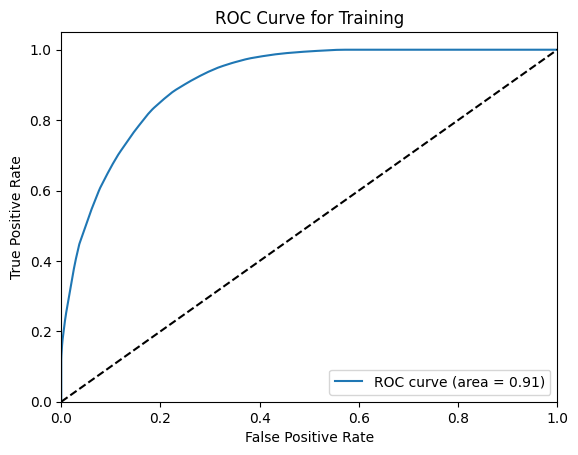

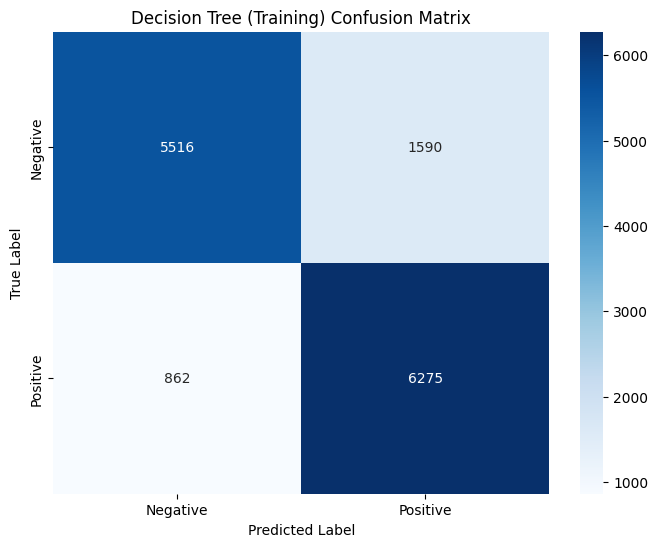


Evaluation Metrics for Validation:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1759
           1       0.76      0.82      0.79      1802

    accuracy                           0.78      3561
   macro avg       0.78      0.78      0.78      3561
weighted avg       0.78      0.78      0.78      3561



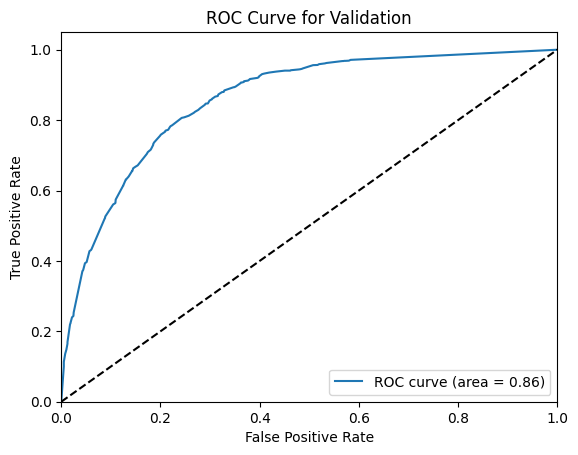

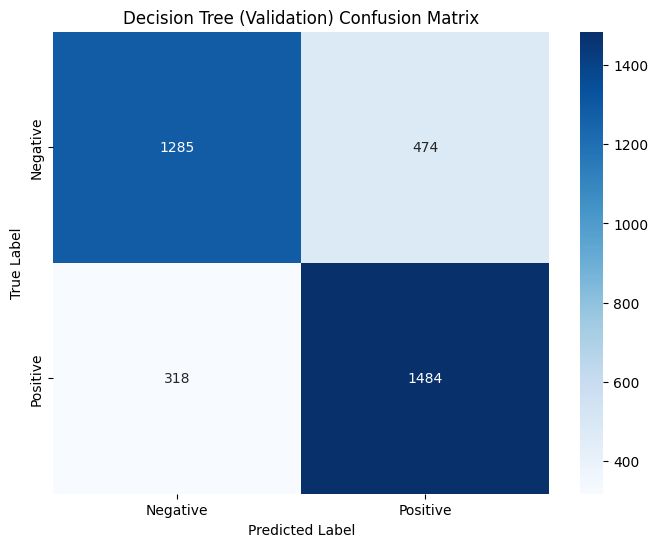

In [43]:
best_dt = DecisionTreeClassifier(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'], 
    min_samples_leaf=best_params_dt['min_samples_leaf'],
    criterion=best_params_dt['criterion'],
    random_state=42
)

best_dt.fit(X_train, y_train)

dt_train_pred = best_dt.predict(X_train)
dt_train_prob = best_dt.predict_proba(X_train)[:, 1] 
dt_val_pred = best_dt.predict(X_val)
dt_val_prob = best_dt.predict_proba(X_val)[:, 1]
dt_val_true = y_val

evaluate_model(y_train, dt_train_pred, dt_train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, dt_train_pred, model_name='Decision Tree (Training)')

evaluate_model(y_val, dt_val_pred, dt_val_prob, dataset_name="Validation") 
plot_confusion_matrix(y_val, dt_val_pred, model_name='Decision Tree (Validation)')

TERCER MODEL: SVM

Trobar la millor combinació de hiperparàmetres per SVM

In [44]:
from sklearn.svm import SVC

svm = SVC(random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='precision', cv=10, n_jobs=-1)

X_train = train_df.drop(columns=['Realornot'])
y_train = train_df['Realornot']

grid_search.fit(X_train, y_train)

best_params_svm = grid_search.best_params_
print(f"Best hyperparameters: {best_params_svm}")

mean_precision = grid_search.cv_results_['mean_test_score'].mean()
std_precision = grid_search.cv_results_['std_test_score'].mean()
print(f"Mean precision: {mean_precision:.4f} (+/- {std_precision:.4f})")

Best hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mean precision: 0.7304 (+/- 0.0130)


Validem el model


Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.88      0.79      0.84      7106
           1       0.81      0.89      0.85      7137

    accuracy                           0.84     14243
   macro avg       0.85      0.84      0.84     14243
weighted avg       0.85      0.84      0.84     14243



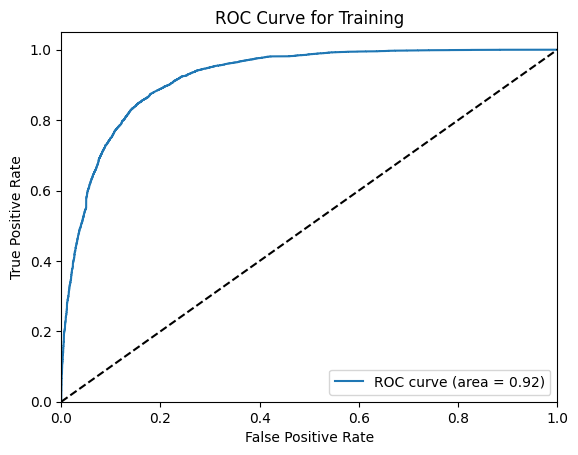

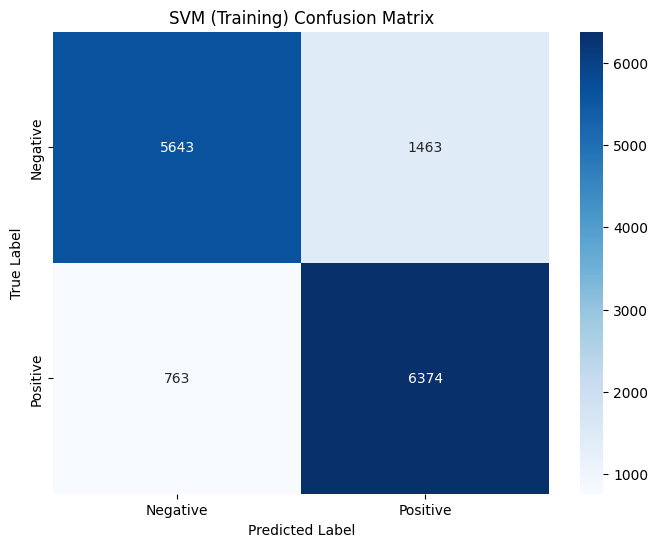


Evaluation Metrics for Validation:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1759
           1       0.82      0.89      0.86      1802

    accuracy                           0.85      3561
   macro avg       0.85      0.85      0.85      3561
weighted avg       0.85      0.85      0.85      3561



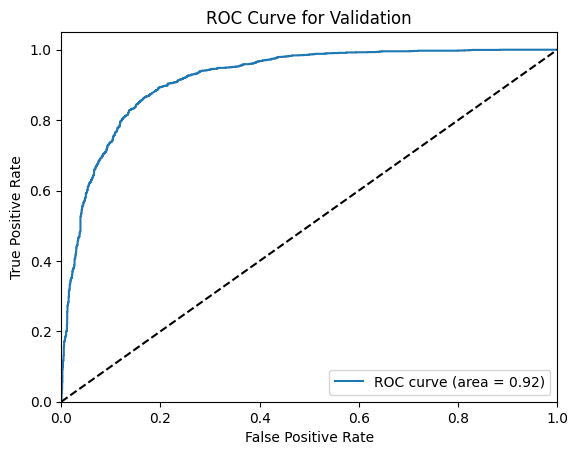

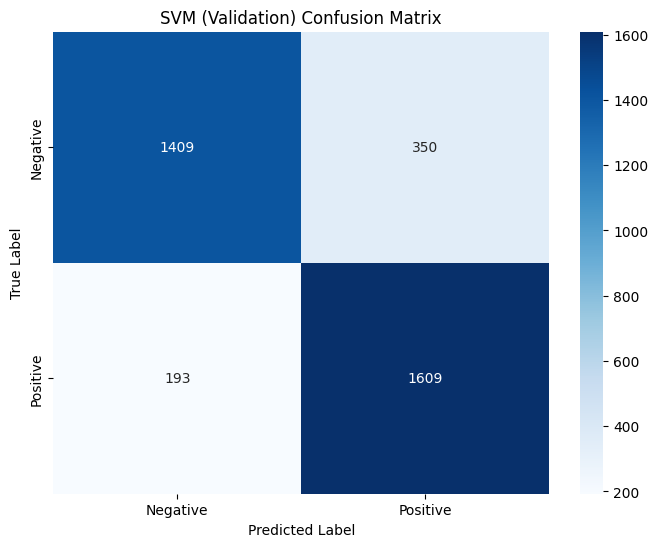

In [45]:
best_svm = SVC(
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'],
    random_state=42,
    probability=True
)
best_svm.fit(X_train, y_train)

svm_train_pred = best_svm.predict(X_train)
svm_train_prob = best_svm.predict_proba(X_train)[:,1]
svm_val_pred = best_svm.predict(X_val)
svm_val_prob = best_svm.predict_proba(X_val)[:,1]
svm_val_true = y_val

evaluate_model(y_train, svm_train_pred, svm_train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, svm_train_pred, model_name='SVM (Training)')

evaluate_model(y_val, svm_val_pred, svm_val_prob, dataset_name="Validation") 
plot_confusion_matrix(y_val, svm_val_pred, model_name='SVM (Validation)')

4. SELECCIÓ DEL MODEL


Best Parameters:
KNN: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}
Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


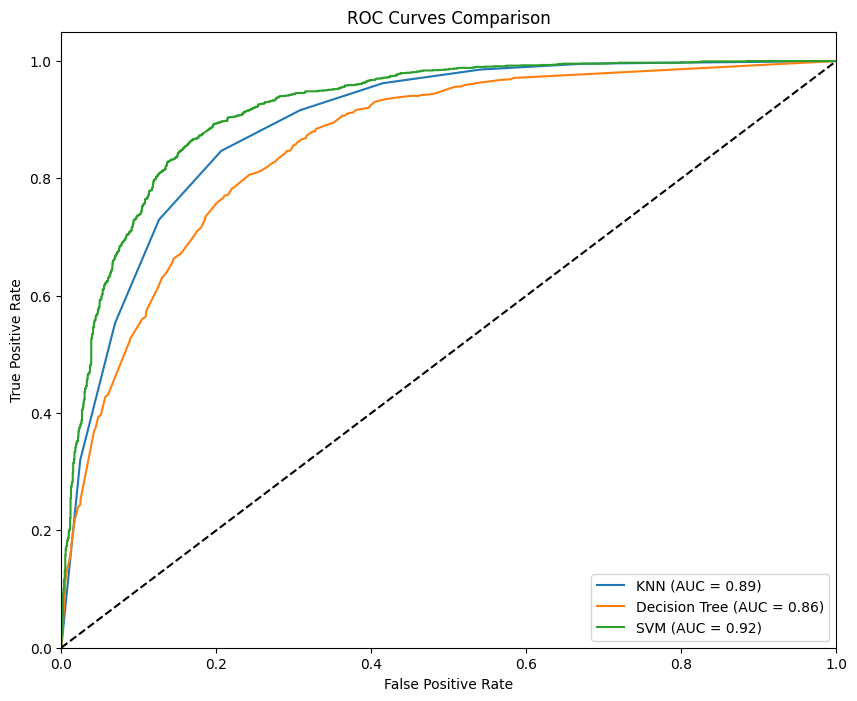

In [46]:
plt.figure(figsize=(10, 8))

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_val, val_prob)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_val, dt_val_prob) 
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_val, svm_val_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")

print("\nBest Parameters:")
print("KNN:", best_params)
print("Decision Tree:", best_params_dt)
print("SVM:", best_params_svm)
plt.show()

Escollim el model SVM. A continuació analitzarem els resultats d'aquests amb la partició de test en comparació amb el train i el val


Evaluation Metrics for Training:
              precision    recall  f1-score   support

           0       0.88      0.79      0.84      7106
           1       0.81      0.89      0.85      7137

    accuracy                           0.84     14243
   macro avg       0.85      0.84      0.84     14243
weighted avg       0.85      0.84      0.84     14243



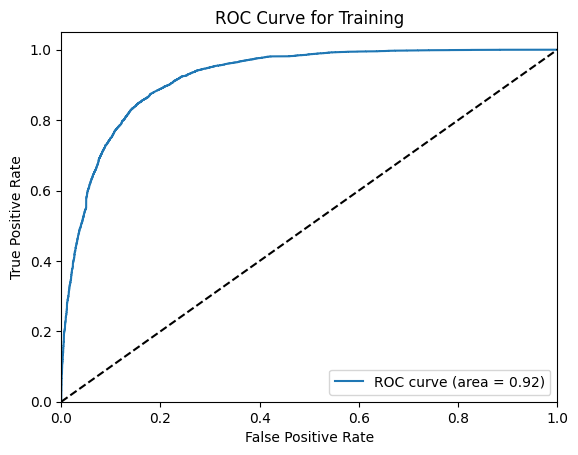

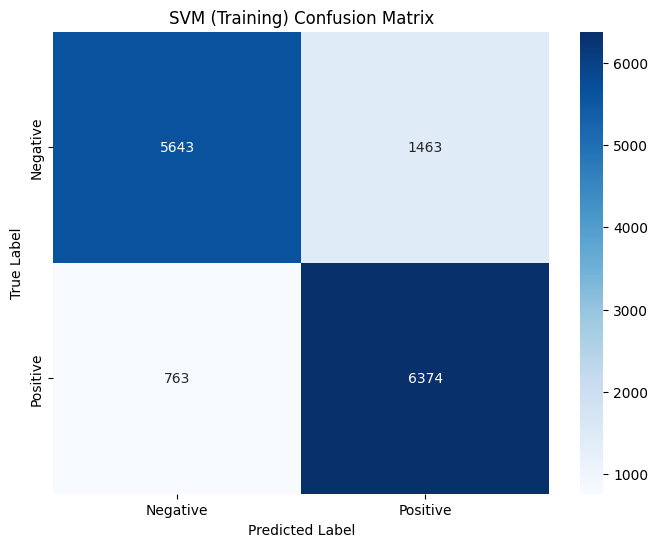


Evaluation Metrics for Test:
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      1172
           1       0.72      0.82      0.77      1200

    accuracy                           0.75      2372
   macro avg       0.75      0.75      0.75      2372
weighted avg       0.75      0.75      0.75      2372



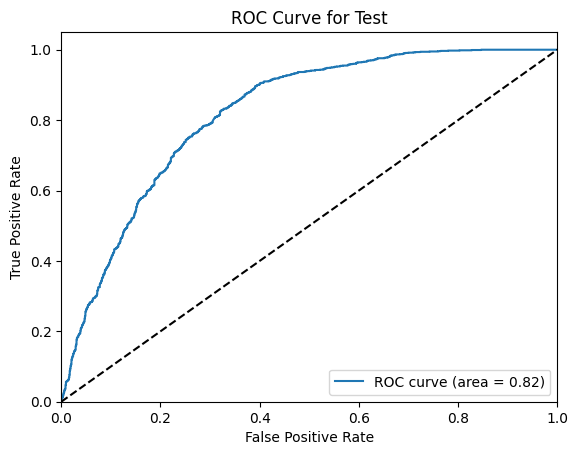

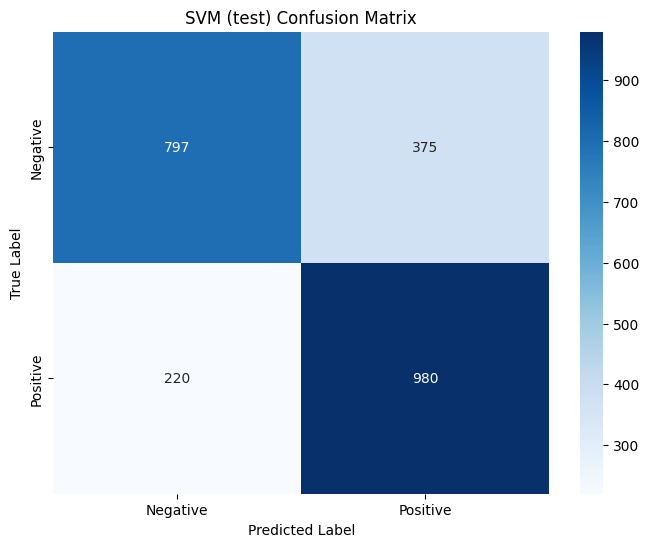

In [47]:
test_data = pd.read_csv('test.csv')
X_test = test_data.drop(columns=['Realornot'])
y_test = test_data['Realornot']

best_svm = SVC(
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'],
    random_state=42,
    probability=True
)
best_svm.fit(X_train, y_train)

svm_train_pred = best_svm.predict(X_train)
svm_train_prob = best_svm.predict_proba(X_train)[:,1]
svm_test_pred = best_svm.predict(X_test)
svm_test_prob = best_svm.predict_proba(X_test)[:,1]
svm_test_true = y_test

evaluate_model(y_train, svm_train_pred, svm_train_prob, dataset_name="Training")
plot_confusion_matrix(y_train, svm_train_pred, model_name='SVM (Training)')

evaluate_model(y_test, svm_test_pred, svm_test_prob, dataset_name="Test") 
plot_confusion_matrix(y_test, svm_test_pred, model_name='SVM (test)')